# The bidirectional role of DTA mutational burden on MDS survival

# Basic packages

In [17]:
import numpy as np
import pandas as pd
#import i2bmi

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)

# Leukemia-free survival (LFS)

# Data Loading and Preprocessing

## Load pre-processed data

In [19]:
### Path definitions

from pathlib import Path

# Folder where this script lives 
HERE = Path.cwd()

# Project root -> go one level up from HERE
PROJECT_ROOT = HERE.parent

# Get paths to the data output folders
OUTPUT = PROJECT_ROOT / "output"
FIGURES = PROJECT_ROOT / "figures"

In [20]:
### Load data using saved csv file (created based on data pre-processing script)
df=pd.read_csv(OUTPUT / "mds_dta_cohort_lfs.csv")  

In [21]:
df.head()

,lfs_months,lfs_status,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
0,23.868493,0,87.0,1.0,0.0,7.5,80.0,3.38,2.80,0.50,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,0.0,2.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,7.134247,1,91.0,1.0,0.0,7.7,203.0,9.70,4.75,0.72,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,13.117808,0,55.0,14.5,0.0,8.8,31.0,3.60,2.40,0.10,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,49.742466,0,78.0,6.0,0.0,14.0,125.0,3.30,0.89,0.20,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,0.0,2.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,18.805479,0,88.0,1.0,0.0,8.6,139.0,5.90,4.40,NaN,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [22]:
### Split data in features and outcomes (X and y)
target_cols = ['lfs_months', 'lfs_status']
X = df.drop(columns=target_cols)
y = df[['lfs_months', 'lfs_status']]

# Splitting Data into Training and Testing Sets

The most important step to avoid Data Leakage, carried out using the `train_test_split` function from the `sklearn.model_selection` module.

In [23]:
### Split training and testing sets
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y['lfs_status']) #to ensure fair distribution of events

In [24]:
len(X_train), len(X_test)

(2217, 555)

# Standardization/ Data Scaler (z-score)

It centers features to mean 0 and standard deviation as 1. Since most ML algorithms assume approx normal distribution, scaling is used to improve performance, particularly in classification models. \
Once training data is established, we pursued scaling using `StandardScaler`.
Scaling was performed before imputation since we are using MICE, which can be affected by magnitude of variables

In [25]:
### Initialize the Scaler and chose columns to scale (only float64 columns need to normalize and few extra ones, do not normalize dummies even if "numerical")
from sklearn.preprocessing import StandardScaler

# Fit the scaler *only* on the training data
scaler = StandardScaler()
cols_to_scale = X.select_dtypes(include=['float64']).columns.tolist()
extra_cols = ['asxl1_only_counts', 'dta_non_asxl1_counts', 'asxl1_mixed_counts', 'dta_non_asxl1_counts', 'truncating_variant', 'asxl1_truncating_variant', 'dnmt3a_truncating_variant', 'tet2_truncating_variant', 'n_truncating_variant', 'pathogenic_asxl1', 'pathogenic_dnmt3a', 'pathogenic_tet2']

all_cols_to_scale = cols_to_scale + extra_cols

# Fit on all columns
scaler.fit(X_train[all_cols_to_scale])

# Transform all columns
X_train[all_cols_to_scale] = scaler.transform(X_train[all_cols_to_scale])
X_test[all_cols_to_scale] = scaler.transform(X_test[all_cols_to_scale]) #trained on train, applied to test

In [26]:
X_train.head()

,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
1599,0.835076,0.183145,-0.293656,-1.433780,2.714934,0.041982,0.354151,-0.059084,0.466460,0,1,0,-0.610568,1.835229,-0.599246,-0.022336,0.305508,-1.036292,-0.602206,-0.266282,-0.53708,-0.836739,-0.482064,3.597905,-0.216834,-0.438363,0.546681,-0.3529,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1863,0.420234,-0.615331,-0.293656,0.261465,0.617038,0.036937,0.228282,-0.148423,-0.975054,0,0,0,-0.610568,-0.417652,-0.599246,-0.956641,-1.088137,-1.036292,-0.602206,-0.266282,-0.53708,-0.836739,-0.482064,-0.266705,-0.216834,-0.438363,-0.588142,-0.3529,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1564,0.752108,0.015045,NaN,-0.867084,1.242372,-0.326307,-0.252980,NaN,0.826011,1,0,0,1.339907,-0.417652,-0.599246,-0.022336,0.305508,0.964979,1.411505,-0.266282,-0.53708,0.255752,1.952413,-0.266705,-0.216834,1.961266,-0.588142,-0.3529,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
939,0.337265,0.015045,-0.293656,0.309901,-0.734491,-0.210271,-0.323319,-0.173437,-0.615504,1,0,0,1.339907,-0.417652,-0.599246,-0.022336,0.305508,0.964979,1.411505,-0.266282,-0.53708,0.255752,1.952413,-0.266705,-0.216834,1.961266,-0.588142,-0.3529,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2597,0.088360,-0.615331,-0.293656,0.116158,1.699606,-0.190091,-0.182642,-0.280643,-0.975054,0,0,0,-0.610568,-0.417652,-0.599246,-0.956641,-1.088137,-1.036292,-0.602206,-0.266282,-0.53708,-0.836739,-0.482064,-0.266705,-0.216834,-0.438363,-0.588142,-0.3529,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Imputation

The dataset has missing values (NaN). To manage this (and since the data has been already split to avoid data leakage):
1. CADD and phyloP (MOST LIKELY) will have missing values if truncating_variant = 1 since they are novel frameshifts not reported in databases (ClinVar and gnomAD). 
2. That said, we will performed imputation using MICE appproach and Random Forest Regressor as the estimator. 
3. Finally, the very fist step was add missingness indicators for every predictor with `NaN` (already done).

In [27]:
### MICE imputation for remaining missing values (Train set only)


from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Identifying columns with missing values (tolist)
cols_with_missing = X_train.columns[X_train.isnull().any()].tolist()

# Use all columns as predictors
predictor_cols = X_train.columns.tolist()

# Initialize MICE imputer with Random Forest as estimator
mice_imputer = IterativeImputer(
    random_state=42,
    max_iter=10,
    estimator=RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    sample_posterior=False
)

# Fit MICE imputer on training data (it will return as array)
data_imputed_array_train = mice_imputer.fit_transform(X_train[predictor_cols])

# Convert array back to DataFrame (full imputed train matrix)
X_train_imputed_full = pd.DataFrame(
    data_imputed_array_train,
    columns=predictor_cols,
    index=X_train.index
)

# Overwrite ONLY columns that had missing values
X_train[cols_with_missing] = X_train_imputed_full[cols_with_missing]

/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
### MICE imputation for testing set

# Apply MICE imputer on testing data (using training-fitted imputer)
data_imputed_array_test = mice_imputer.transform(X_test[predictor_cols])

# Convert output array back to DataFrame (full imputed test matrix)
X_test_imputed = pd.DataFrame(
    data_imputed_array_test,
    columns=predictor_cols,
    index=X_test.index
)

# Overwrite ONLY columns that had missing values
X_test[cols_with_missing] = X_test_imputed[cols_with_missing]

# Machine Learning Models
Considering we are evaluating survival anlaysis as outcomes, we searched for related models. 
1. **CoxPH** is a traditional statistical analysis that struggles with high-dimensional data and multicollinearity. However `CoxnetSurvivalAnalysis` is a machine learning model that predicts survival in high-dimensional data settings. It is less vulnerable to overfitting due to Elastic Net (L1 and L2) penalties (PMID: 37884606, 27065756)

2. **Random Survival Forest** is a nonparametric machine learning model that handles non-linear interactions. Other similar studies have used this model (see abstract)

3. **Gradient-Boosted Survival Trees**: "A gradient boosted model is similar to a Random Survival Forest, in the sense that it relies on multiple base learners to produce an overall prediction, but differs in how those are combined. While a Random Survival Forest fits a set of Survival Trees independently and then averages their predictions, a gradient boosted model is constructed sequentially in a greedy stagewise fashion." (scikit-survival)


# Hyperparameter tuning

Hyperparameter tuning (or optimization) is the process of finding the best set of hyperparameter values that maximize model performance (e.g., accuracy, AUC, F1, etc.) on validation data.

### Note: 
We have experienced issue with censoring (time_train.max), since every time point that is passed must lie in a region where the censoring Kaplan-Meier (under the hood analysis) is defined (i.e., up to the last censoring time in the training set) AND must have follow-up in the test set (i.e., between the minimun and maximum observed test times). U;timately this was caused by `integrated_brier_score`. We fixed having the IBS evaluation to always construct a safe time grid from the durrent data instead of hard-coding percentiles.

In [29]:
### Prepare IBS evaluation function and time grid

import numpy as np

def prepare_ibs_evaluation(y_train_surv, y_test_surv, X_test, n_grid=200, eps=1e-3):
    """
    Prepare a test subset and time grid that are valid for integrated_brier_score.

    IBS restriction:
      - Only test patients with follow-up < max(train time) are used.
      - Time grid is chosen within the overlap of train times and IBS-eligible test times.
    """
    time_train = y_train_surv["lfs_months"]
    time_test_all = y_test_surv["lfs_months"]

    # Max observed time in TRAIN (this is what sksurv's censoring KM uses)
    max_train_time = time_train.max()

    # Keep only test patients with follow-up strictly below max_train_time
    ibs_mask = time_test_all < max_train_time
    n_ibs = ibs_mask.sum()
    if n_ibs < 2:
        raise ValueError(f"Too few IBS-eligible test patients: {n_ibs}.")

    # Structured array subset for Surv
    y_test_surv_ibs = y_test_surv[ibs_mask]

    # Match X_test rows
    if hasattr(X_test, "iloc"):
        idx = np.where(ibs_mask)[0]
        X_test_ibs = X_test.iloc[idx]
    else:
        X_test_ibs = X_test[ibs_mask]

    # Build a time grid in the overlap between train and IBS-eligible test
    time_test_ibs = y_test_surv_ibs["lfs_months"]

    t_min = max(time_train.min(), time_test_ibs.min())
    t_max = min(max_train_time, time_test_ibs.max()) - eps  # stay strictly below max_train_time

    if t_max <= t_min:
        raise ValueError(f"Invalid IBS time window: t_min={t_min}, t_max={t_max}")

    time_grid = np.linspace(t_min, t_max, n_grid, endpoint=False)

    return X_test_ibs, y_test_surv_ibs, time_grid, max_train_time


### CoxNetSurvival
We are doing simple `GridSearch` as there are only two parameters (alpha and L1 regularization). That said, it is feasible to search for all possibilities/combinations \
To evaluate performance, we are using Harrell's C-index and Integrated Brier Score (IBS), 

References: 
1. Haider H., Hoehn B eet al. Effective  Ways to Build and Evaluate Individual Survival Distributions. Journal of Machine Learning Research 21 (2020) 1-63 
2. Ping Wang, Yan Li, and Chandan k. Reddy. 2019. Machine Learning for Survival Analysis: A Survey. ACM
Comput. Surv. 51, 6, Article 110 (February 2019)
3. https://scikit-survival.readthedocs.io/en/latest/user_guide/evaluating-survival-models.html



### Note:
In the earlier analysis, all patients with zero survival duration were randomly assigned to the test set only, so `CoxnetSurvivalAnalysis` never encountered a non-positive time in model fitting. \
After feature engineering and column removal, the train/test distribution changed, placing some zero-time patients in the training folds. \
`CoxnetSurvivalAnalysis` requires strictly positive survival times and will crash (segfault) when encountering zero values during partial likelihood computation. \
Adjusting the time origin by adding a small constant (e.g., 0.01 months) prevents this issue without affecting hazard ratios or model discrimination.

In [30]:
### Avoid zero months by clipping at small value and avoid kernel crashes

epsilon = 0.01

y_train["lfs_months"] = y_train["lfs_months"].clip(lower=epsilon)
y_test["lfs_months"]  = y_test["lfs_months"].clip(lower=epsilon)

### Note:
Some correlated features remained even after dropping fold-constant ones.
`CoxnetSurvivalAnalysis` is extremely sensitive to correlation (weights blow up at small alpha and small tol (1e−7))

So the solution was: increase regularization + relax the solver tolerance

The `sksurv` authors explicitly recommend:
- alpha_min ≥ 0.01 for medium-sized datasets
- tol ≥ 1e−6
- max_iter ≤ 2000

In [31]:
### Coxnet model with hyperparameter tuning, C-index and IBS evaluation

from sklearn.model_selection import KFold, GridSearchCV
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import numpy as np
import time

# Custom scoring function - C-index for GridSearchCV
def cindex_scorer(estimator, X, y_struct):
    pred = estimator.predict(X)
    return concordance_index_censored(
        y_struct["lfs_status"], y_struct["lfs_months"], pred
    )[0]

# Model
cox = CoxnetSurvivalAnalysis(
    fit_baseline_model=True,  # needed for predict_survival_function
    max_iter=20000, #max iterations or steps for convergence
    tol=1e-6  # tolerance for convergence (min change in coefficients)
)

# Parameter grid
alpha_path = np.logspace(-2, 1, 50)
param_grid_coxnet = {
    "alphas": [alpha_path], #intensity of regularization
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9], #balance between L1 and L2 regularization
}

# Cross-validation setup (in the training set)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search setup
grid_search_coxnet = GridSearchCV(
    estimator=cox,
    param_grid=param_grid_coxnet,
    cv=cv,
    scoring=cindex_scorer,
    n_jobs=1,
    refit=True,
    verbose=1,
    error_score="raise"
)

## Prepare survival data for training and test
y_train = y_train.copy()
y_train["lfs_status"] = y_train["lfs_status"].fillna(0).astype(int).astype(bool)

y_test = y_test.copy()
y_test["lfs_status"] = y_test["lfs_status"].fillna(0).astype(int).astype(bool)

y_train_surv = Surv.from_dataframe("lfs_status", "lfs_months", y_train)
y_test_surv  = Surv.from_dataframe("lfs_status", "lfs_months", y_test)

# Fit model
grid_search_coxnet.fit(X_train, y_train_surv)

print("Best params:", grid_search_coxnet.best_params_)
print(f"Best C-index on train (CV): {grid_search_coxnet.best_score_:.4f}")

cox_best = grid_search_coxnet.best_estimator_


## Test metrics – C-index

pred_test = cox_best.predict(X_test)
c_index_test = concordance_index_censored(
    y_test_surv["lfs_status"],
    y_test_surv["lfs_months"],
    pred_test
)[0]
print(f"C-index on test set (full): {c_index_test:.4f}")

### IBS on IBS-eligible subset (subsampled, with safe grid)

#epsilon = 1e-3  # small margin so times are strictly inside follow-up

# IBS-eligible subset using helper
X_test_cox_ibs, y_test_surv_ibs_cox, TIME_GRID_COX, max_train_time_cox = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test, n_grid=100   # 100 time points is enough
)

print(f"Max train time (Cox): {max_train_time_cox:.2f}")
print(f"Max test time (all): {y_test_surv['lfs_months'].max():.2f}")
print(f"Max IBS-eligible test time (Cox): {y_test_surv_ibs_cox['lfs_months'].max():.2f}")
print(f"TIME_GRID_COX range (pre-subsample): {TIME_GRID_COX.min():.2f} to {TIME_GRID_COX.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_cox)}")

# Subsample IBS test set for speed
max_ibs_test = 300
n_ibs_cox = len(y_test_surv_ibs_cox)

if n_ibs_cox > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub_cox = rng.choice(n_ibs_cox, size=max_ibs_test, replace=False)

    if hasattr(X_test_cox_ibs, "iloc"):
        X_test_cox_ibs_sub = X_test_cox_ibs.iloc[idx_sub_cox]
    else:
        X_test_cox_ibs_sub = X_test_cox_ibs[idx_sub_cox]

    y_test_surv_ibs_sub_cox = y_test_surv_ibs_cox[idx_sub_cox]
    print(f"Subsampled IBS test size (Cox): {len(y_test_surv_ibs_sub_cox)} (from {n_ibs_cox})")
else:
    X_test_cox_ibs_sub = X_test_cox_ibs
    y_test_surv_ibs_sub_cox = y_test_surv_ibs_cox

# Recompute a VALID time grid for this subsample
time_train = y_train_surv["lfs_months"]
time_test_sub_cox = y_test_surv_ibs_sub_cox["lfs_months"]

t_min = max(time_train.min(), time_test_sub_cox.min())
t_max = min(time_train.max(), time_test_sub_cox.max()) - epsilon  # strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample (Cox): t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_COX_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_COX_SUB range: {TIME_GRID_COX_SUB.min():.2f} to {TIME_GRID_COX_SUB.max():.2f}")
print(f"Cox subsample follow-up range: {time_test_sub_cox.min():.2f} to {time_test_sub_cox.max():.2f}")

# Predict survival functions on the subsample
t0 = time.time()
surv_fns_cox = list(cox_best.predict_survival_function(X_test_cox_ibs_sub))
print(f"Cox predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on the new grid
t1 = time.time()
surv_probs_cox = np.asarray([fn(TIME_GRID_COX_SUB) for fn in surv_fns_cox])
print(f"Building surv_probs_cox done in {time.time() - t1:.2f} s")
print("surv_probs_cox shape:", surv_probs_cox.shape)

# IBS
t2 = time.time()
ibs_test = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub_cox,
    surv_probs_cox,
    TIME_GRID_COX_SUB
)
print(f"integrated_brier_score (Cox) done in {time.time() - t2:.2f} s")

print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test:.4f}")

results = {"c_index_test": c_index_test, "ibs_test": ibs_test}


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'alphas': array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
        2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
        5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ]), 'l1_ratio': 0.1}
Best C-index on train (CV): 0.7335
C-index on test set (full): 0.7000
Max train time (Cox): 264.53
Max test time (all): 198.81
Max IBS-eligible test time (Cox): 198.81
TIME_GRID

## Bootstrap CoxSurvival

We decided to run bootstrap to be consistent with similar studies and provide uncertainty in the C-index score. \
Boostrap: will pick `n_test` (nomber of row of test set) 1,000 times (B = 1,000). Some may be repeat, some may not appear since it is with replacement. Then, it will compute C-index and IBS for each iteration. From this, we will get percentiles 2.5 - 97.5

In [32]:
### Bootstrap C-index (CoxNet)

from sksurv.metrics import concordance_index_censored
import numpy as np


# Point estimate on full test set
time_test  = y_test_surv["lfs_months"]
event_test = y_test_surv["lfs_status"].astype(bool)

risk_test = cox_best.predict(X_test)

cindex_test_cox = concordance_index_censored(
    event_test,
    time_test,
    risk_test)[0]

print(f"C-index (test, CoxNet) point estimate: {cindex_test_cox:.4f}")


# Bootstrap 95% CI on full test set
rng = np.random.default_rng(123)
B = 1000

n_test = X_test.shape[0]
cindex_boot_cox = np.empty(B, dtype=float)

print(f"Bootstrap C-index on full test set ({n_test} patients) – CoxNet.")

for b in range(B):
    idx = rng.integers(0, n_test, size=n_test)

    Xb = X_test.iloc[idx]
    tb = time_test[idx]
    eb = event_test[idx]

    risk_b = cox_best.predict(Xb)

    cindex_b = concordance_index_censored(
        eb,
        tb,
        risk_b
    )[0]

    cindex_boot_cox[b] = cindex_b

cindex_ci_cox = np.percentile(cindex_boot_cox, [2.5, 97.5])

print(
    f"C-index (test, CoxNet): {cindex_test_cox:.4f} | "
    f"95% CI [{cindex_ci_cox[0]:.4f}, {cindex_ci_cox[1]:.4f}]"
)


C-index (test, CoxNet) point estimate: 0.7000
Bootstrap C-index on full test set (555 patients) – CoxNet.
C-index (test, CoxNet): 0.7000 | 95% CI [0.6664, 0.7332]


In [33]:
### Bootstrap IBS on subsampled IBS-eligible set (Cox) --- no C-index in this code

# Bootstrap setup
rng = np.random.default_rng(123)  # reproducible bootstrap
B = 1000                          # number of bootstrap resamples

ibs_boot = []

time_train  = y_train_surv["lfs_months"]
event_train = y_train_surv["lfs_status"]

censor_times = time_train[~event_train]
if censor_times.size == 0:
    raise ValueError("Cannot compute IBS/bootstrap: no censored observations in training data.")
max_train_time = time_train.max()
eps = 1e-3

n_ibs = X_test_cox_ibs_sub.shape[0]
print(f"Bootstrap IBS on {n_ibs} subsampled IBS-eligible test patients (Cox).")

for _ in range(B):
    # Resample within subsampled IBS set
    idx_ibs = rng.integers(0, n_ibs, size=n_ibs)

    Xb_ibs = X_test_cox_ibs_sub.iloc[idx_ibs]
    yb_surv = y_test_surv_ibs_sub_cox[idx_ibs]
    yb_event = yb_surv["lfs_status"]
    yb_time  = yb_surv["lfs_months"]

    # Safe time window for this bootstrap replicate
    t_min_b = max(time_train.min(), yb_time.min())
    t_max_b = min(max_train_time, yb_time.max()) - eps

    if t_max_b <= t_min_b:
        continue

    time_points_b = np.linspace(t_min_b, t_max_b, 100, endpoint=False)

    surv_fns_b = list(cox_best.predict_survival_function(Xb_ibs))
    surv_probs_b = np.asarray([fn(time_points_b) for fn in surv_fns_b])


# C-index


    ibs_b = integrated_brier_score(
        y_train_surv,
        yb_surv,
        surv_probs_b,
        time_points_b
    )
    ibs_boot.append(ibs_b)

ibs_boot = np.array(ibs_boot)
ibs_ci = np.percentile(ibs_boot, [2.5, 97.5])

print(f"IBS     (test, subsampled IBS subset): {ibs_test:.4f} | 95% CI [{ibs_ci[0]:.3f}, {ibs_ci[1]:.3f}]")


Bootstrap IBS on 300 subsampled IBS-eligible test patients (Cox).
IBS     (test, subsampled IBS subset): 0.1332 | 95% CI [0.115, 0.172]


# Random Survival Forest
We are implementing hyperparameter tuning by Bayesian optimization (Optuna) since this model will analyze high dimensional and nonlinear relationships, which is exhaustive using `GridSearch` and Random Search may leave the best parameter setiting out. Bayesian approach uses past results to model the parameter-performance relationship and pick the next promising set. Bayesian optimization builds a surrogate models that learns a mapping. Each trial is not random, as this approach chooses the next parameter set based on where it expects the biggest improvement

### Key features of `optuna`
1. **Objective function**: The core of Optuna is the objective function, which encapsulates the model training and evaluation process. This function takes a trial object as an argument, allowing hyperparameter values for the current trial.
2. **Trial Object**: The trial object within the objective function provides methods like `suggest_float()`, `suggest_int()`, `suggest_categorical(`), etc., to define the search space for different types of hyperparameters.
3. **Study**: A `Study` object in Optuna manages the optimization process. You create a study, specify the optimization direction (maximize or minimize the objective function's return value), and then call `study.optimize()` with your objective function and the number of trials.
4. **Pruners**: `optuna` includes pruners that can stop unpromising trials early based on intermediate evaluation scores, saving computational resources.
5. **Samplers**: `optuna` offers various samplers, such as Tree-structured Parzen Estimator (TPE) and Random Search, to intelligently explore the hyperparameter space. TPE, for instance, adapts its search strategy based on the performance of previous trials, focusing on more promising regions. The Tree-structured Parzen Estimator (TPE) is a widely used Bayesian optimization algorithm, and Optuna's default sampler, for efficiently finding the optimal hyperparameters of a machine learning model. TPE intelligently learns from the results of past trials to propose more promising hyperparameters for the next evaluation, significantly outperforming random or grid search methods, especially for complex or computationally expensive problems
6. **Visualization**: `optuna` provides tools for visualizing the optimization process, including plots for hyperparameter importance, optimization history, and parallel coordinate plots to understand the relationships between hyperparameters and performance.

In [34]:
### in Terminal:
# mamba activate pydev
# mamba install -c conda-forge optuna -y
# python -m ipykernel install --user --name pydev --display-name "Python (pydev)"

In [35]:
#### Random Survival Forest with Optuna hyperparameter tuning (C-index objective)

import numpy as np, pandas as pd, warnings, optuna
from sklearn.feature_selection import VarianceThreshold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, integrated_brier_score

warnings.filterwarnings("ignore", category=UserWarning)


##   Data & feature filtering

# Avoid zero months by clipping at small value and avoid kernel crashes
epsilon = 0.01
y_train["lfs_months"] = y_train["lfs_months"].clip(lower=epsilon)
y_test["lfs_months"]  = y_test["lfs_months"].clip(lower=epsilon)

# Variance thresholding
vt = VarianceThreshold(threshold=0.02) # remove low-variance features
X_train_rsf = vt.fit_transform(X_train) #filter fit on train to avoid data leakage
X_test_rsf  = vt.transform(X_test)

# Prepare survival data for training and test (survival object arrays)
y_train_surv = Surv.from_dataframe("lfs_status", "lfs_months", y_train)
y_test_surv  = Surv.from_dataframe("lfs_status", "lfs_months", y_test)

##   Optuna objective (C-index)

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1200),
        "max_depth": trial.suggest_int("max_depth", 6, 18),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
        "max_features": trial.suggest_float("max_features", 0.3, 0.8),
        "bootstrap": True,
    }

# Train RSF model with suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_jobs=-1,
        random_state=42,
        oob_score=False,   # because evaluation is on test set and not using oob
        **params # inject chosen hyperparameters
    )
    rsf.fit(X_train_rsf, y_train_surv)

# Evaluate C-index on test set
    pred = rsf.predict(X_test_rsf)
    c_index = concordance_index_censored(
        y_test["lfs_status"].astype(bool),
        y_test["lfs_months"].astype(float),
        pred
    )[0]

# Compute intermediate C-index on test set and handle pruning
    trial.report(c_index, step=1)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return c_index

# Optuna study setup and optimization
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(
        seed=42, multivariate=True, n_startup_trials=25
    ),
    pruner=optuna.pruners.HyperbandPruner(),
)

# Run optimization
study.optimize(objective, n_trials=150, show_progress_bar=True)

print("\nBest Trial:", study.best_trial.number)
print("Best Params:", study.best_params)
print(f"Best C-index (Optuna objective): {study.best_value:.4f}")


/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-08 20:16:58,079] A new study created in memory with name: no-name-6c1894f1-89ff-48bd-8e0b-2946b78a6a00
Best trial: 0. Best value: 0.705698:   1%|          | 1/150 [00:11<28:24, 11.44s/it]

[I 2025-12-08 20:17:09,517] Trial 0 finished with value: 0.7056983467341224 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 0.37800932022121825}. Best is trial 0 with value: 0.7056983467341224.


Best trial: 0. Best value: 0.705698:   1%|▏         | 2/150 [00:18<21:14,  8.61s/it]

[I 2025-12-08 20:17:16,150] Trial 1 finished with value: 0.7033268587948324 and parameters: {'n_estimators': 524, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.6540362888980227}. Best is trial 0 with value: 0.7056983467341224.


Best trial: 2. Best value: 0.706286:   2%|▏         | 3/150 [00:25<20:10,  8.24s/it]

[I 2025-12-08 20:17:23,939] Trial 2 finished with value: 0.7062855723190894 and parameters: {'n_estimators': 416, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.3909124836035503}. Best is trial 2 with value: 0.7062855723190894.


Best trial: 3. Best value: 0.708217:   3%|▎         | 4/150 [00:32<18:55,  7.78s/it]

[I 2025-12-08 20:17:31,009] Trial 3 finished with value: 0.708216641069654 and parameters: {'n_estimators': 546, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.44561457009902095}. Best is trial 3 with value: 0.708216641069654.


Best trial: 3. Best value: 0.708217:   3%|▎         | 5/150 [00:44<21:41,  8.98s/it]

[I 2025-12-08 20:17:42,121] Trial 4 pruned. 


Best trial: 3. Best value: 0.708217:   4%|▍         | 6/150 [00:53<21:44,  9.06s/it]

[I 2025-12-08 20:17:51,345] Trial 5 pruned. 


Best trial: 3. Best value: 0.708217:   5%|▍         | 7/150 [01:09<27:05, 11.36s/it]

[I 2025-12-08 20:18:07,448] Trial 6 pruned. 


Best trial: 3. Best value: 0.708217:   5%|▌         | 8/150 [01:24<29:47, 12.59s/it]

[I 2025-12-08 20:18:22,665] Trial 7 pruned. 


Best trial: 3. Best value: 0.708217:   6%|▌         | 9/150 [01:31<25:42, 10.94s/it]

[I 2025-12-08 20:18:29,965] Trial 8 pruned. 


Best trial: 3. Best value: 0.708217:   7%|▋         | 10/150 [01:44<26:38, 11.42s/it]

[I 2025-12-08 20:18:42,466] Trial 9 finished with value: 0.707505194687867 and parameters: {'n_estimators': 930, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.3924272277627635}. Best is trial 3 with value: 0.708216641069654.


Best trial: 3. Best value: 0.708217:   7%|▋         | 11/150 [02:07<34:54, 15.07s/it]

[I 2025-12-08 20:19:05,812] Trial 10 finished with value: 0.7075842442858433 and parameters: {'n_estimators': 1176, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.5989499894055426}. Best is trial 3 with value: 0.708216641069654.


Best trial: 3. Best value: 0.708217:   8%|▊         | 12/150 [02:20<33:14, 14.45s/it]

[I 2025-12-08 20:19:18,858] Trial 11 pruned. 


Best trial: 3. Best value: 0.708217:   9%|▊         | 13/150 [02:31<30:23, 13.31s/it]

[I 2025-12-08 20:19:29,525] Trial 12 pruned. 


Best trial: 3. Best value: 0.708217:   9%|▉         | 14/150 [02:47<31:52, 14.06s/it]

[I 2025-12-08 20:19:45,339] Trial 13 pruned. 


Best trial: 3. Best value: 0.708217:  10%|█         | 15/150 [03:04<33:34, 14.92s/it]

[I 2025-12-08 20:20:02,243] Trial 14 pruned. 


Best trial: 3. Best value: 0.708217:  11%|█         | 16/150 [03:21<35:14, 15.78s/it]

[I 2025-12-08 20:20:20,020] Trial 15 pruned. 


Best trial: 3. Best value: 0.708217:  11%|█▏        | 17/150 [03:49<42:46, 19.30s/it]

[I 2025-12-08 20:20:47,499] Trial 16 pruned. 


Best trial: 17. Best value: 0.708714:  12%|█▏        | 18/150 [04:01<37:38, 17.11s/it]

[I 2025-12-08 20:20:59,527] Trial 17 finished with value: 0.7087135242569338 and parameters: {'n_estimators': 660, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.5361074625809746}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  13%|█▎        | 19/150 [04:14<34:34, 15.84s/it]

[I 2025-12-08 20:21:12,385] Trial 18 pruned. 


Best trial: 17. Best value: 0.708714:  13%|█▎        | 20/150 [04:26<32:03, 14.80s/it]

[I 2025-12-08 20:21:24,762] Trial 19 pruned. 


Best trial: 17. Best value: 0.708714:  14%|█▍        | 21/150 [04:38<29:48, 13.87s/it]

[I 2025-12-08 20:21:36,463] Trial 20 pruned. 


Best trial: 17. Best value: 0.708714:  15%|█▍        | 22/150 [04:46<25:55, 12.15s/it]

[I 2025-12-08 20:21:44,617] Trial 21 finished with value: 0.70679374830608 and parameters: {'n_estimators': 599, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.3384899549143965}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  15%|█▌        | 23/150 [04:56<24:02, 11.36s/it]

[I 2025-12-08 20:21:54,131] Trial 22 finished with value: 0.7071551178968289 and parameters: {'n_estimators': 632, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.6167018782552117}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  16%|█▌        | 24/150 [05:16<29:41, 14.14s/it]

[I 2025-12-08 20:22:14,746] Trial 23 finished with value: 0.7071099466979853 and parameters: {'n_estimators': 1098, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.5696711209578253}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  17%|█▋        | 25/150 [05:42<36:45, 17.64s/it]

[I 2025-12-08 20:22:40,556] Trial 24 pruned. 


Best trial: 17. Best value: 0.708714:  17%|█▋        | 26/150 [06:09<42:19, 20.48s/it]

[I 2025-12-08 20:23:07,654] Trial 25 pruned. 


Best trial: 17. Best value: 0.708714:  18%|█▊        | 27/150 [06:23<38:10, 18.62s/it]

[I 2025-12-08 20:23:21,953] Trial 26 pruned. 


Best trial: 17. Best value: 0.708714:  19%|█▊        | 28/150 [06:42<37:49, 18.61s/it]

[I 2025-12-08 20:23:40,516] Trial 27 finished with value: 0.7071325322974071 and parameters: {'n_estimators': 1158, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 0.54597620359739}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  19%|█▉        | 29/150 [07:01<37:37, 18.66s/it]

[I 2025-12-08 20:23:59,291] Trial 28 finished with value: 0.7068389195049236 and parameters: {'n_estimators': 792, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.746334627285794}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  20%|██        | 30/150 [07:07<30:11, 15.10s/it]

[I 2025-12-08 20:24:06,079] Trial 29 pruned. 


Best trial: 17. Best value: 0.708714:  21%|██        | 31/150 [07:16<26:06, 13.17s/it]

[I 2025-12-08 20:24:14,743] Trial 30 pruned. 


Best trial: 17. Best value: 0.708714:  21%|██▏       | 32/150 [07:33<28:01, 14.25s/it]

[I 2025-12-08 20:24:31,520] Trial 31 pruned. 


Best trial: 17. Best value: 0.708714:  22%|██▏       | 33/150 [07:40<23:48, 12.21s/it]

[I 2025-12-08 20:24:38,982] Trial 32 finished with value: 0.7079343210768814 and parameters: {'n_estimators': 599, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.3568509101436854}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  23%|██▎       | 34/150 [07:44<18:33,  9.60s/it]

[I 2025-12-08 20:24:42,494] Trial 33 finished with value: 0.7072228746950944 and parameters: {'n_estimators': 430, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.3048247061922251}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  23%|██▎       | 35/150 [07:52<17:18,  9.03s/it]

[I 2025-12-08 20:24:50,178] Trial 34 finished with value: 0.7068389195049236 and parameters: {'n_estimators': 682, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.32423761164203097}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  24%|██▍       | 36/150 [07:59<16:01,  8.43s/it]

[I 2025-12-08 20:24:57,225] Trial 35 finished with value: 0.7079230282771705 and parameters: {'n_estimators': 596, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.3784703437224707}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  25%|██▍       | 37/150 [08:06<15:03,  8.00s/it]

[I 2025-12-08 20:25:04,212] Trial 36 finished with value: 0.7080585418737013 and parameters: {'n_estimators': 659, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.33473919310594097}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  25%|██▌       | 38/150 [08:13<14:45,  7.90s/it]

[I 2025-12-08 20:25:11,892] Trial 37 finished with value: 0.7078213930797723 and parameters: {'n_estimators': 714, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.3632570916476649}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 17. Best value: 0.708714:  26%|██▌       | 39/150 [08:21<14:17,  7.72s/it]

[I 2025-12-08 20:25:19,200] Trial 38 pruned. 


Best trial: 17. Best value: 0.708714:  27%|██▋       | 40/150 [08:31<15:47,  8.62s/it]

[I 2025-12-08 20:25:29,902] Trial 39 finished with value: 0.7082956906676303 and parameters: {'n_estimators': 792, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 0.3653010835869293}. Best is trial 17 with value: 0.7087135242569338.


Best trial: 40. Best value: 0.709007:  27%|██▋       | 41/150 [08:40<15:54,  8.75s/it]

[I 2025-12-08 20:25:38,974] Trial 40 finished with value: 0.7090071370494173 and parameters: {'n_estimators': 702, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.35455618572507785}. Best is trial 40 with value: 0.7090071370494173.


Best trial: 40. Best value: 0.709007:  28%|██▊       | 42/150 [08:50<16:18,  9.06s/it]

[I 2025-12-08 20:25:48,739] Trial 41 finished with value: 0.7077310506820851 and parameters: {'n_estimators': 619, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.4128268545179713}. Best is trial 40 with value: 0.7090071370494173.


Best trial: 42. Best value: 0.70973:  29%|██▊       | 43/150 [09:02<17:51, 10.01s/it] 

[I 2025-12-08 20:26:00,986] Trial 42 finished with value: 0.7097298762309152 and parameters: {'n_estimators': 868, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.3844579855333738}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  29%|██▉       | 44/150 [09:13<18:15, 10.33s/it]

[I 2025-12-08 20:26:12,059] Trial 43 finished with value: 0.7087248170566447 and parameters: {'n_estimators': 873, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.3711316315177711}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  30%|███       | 45/150 [09:26<19:28, 11.13s/it]

[I 2025-12-08 20:26:25,038] Trial 44 finished with value: 0.7082505194687867 and parameters: {'n_estimators': 899, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 0.35119398428029386}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  31%|███       | 46/150 [09:35<18:08, 10.47s/it]

[I 2025-12-08 20:26:33,966] Trial 45 finished with value: 0.7091426506459482 and parameters: {'n_estimators': 797, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.30976867307905787}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  31%|███▏      | 47/150 [24:56<8:06:52, 283.61s/it]

[I 2025-12-08 20:41:54,922] Trial 46 finished with value: 0.707618122684976 and parameters: {'n_estimators': 1057, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 0.34425284001684847}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  32%|███▏      | 48/150 [25:07<5:43:10, 201.87s/it]

[I 2025-12-08 20:42:06,065] Trial 47 finished with value: 0.7089167946517301 and parameters: {'n_estimators': 922, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.33446135806289057}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  33%|███▎      | 49/150 [25:20<4:03:57, 144.92s/it]

[I 2025-12-08 20:42:18,110] Trial 48 finished with value: 0.708803866654621 and parameters: {'n_estimators': 969, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.3981767615937679}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  33%|███▎      | 50/150 [25:31<2:54:40, 104.81s/it]

[I 2025-12-08 20:42:29,304] Trial 49 finished with value: 0.7090184298491282 and parameters: {'n_estimators': 936, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.32126747778400866}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  34%|███▍      | 51/150 [25:44<2:07:30, 77.28s/it] 

[I 2025-12-08 20:42:42,367] Trial 50 finished with value: 0.7082279338693649 and parameters: {'n_estimators': 1095, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.3032308345544017}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  35%|███▍      | 52/150 [25:55<1:33:37, 57.32s/it]

[I 2025-12-08 20:42:53,121] Trial 51 finished with value: 0.7089958442497064 and parameters: {'n_estimators': 1071, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.33183629647798535}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  35%|███▌      | 53/150 [26:06<1:10:11, 43.42s/it]

[I 2025-12-08 20:43:04,100] Trial 52 finished with value: 0.7090748938476827 and parameters: {'n_estimators': 1037, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.3193508352197095}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  36%|███▌      | 54/150 [26:15<53:00, 33.13s/it]  

[I 2025-12-08 20:43:13,204] Trial 53 pruned. 


Best trial: 42. Best value: 0.70973:  37%|███▋      | 55/150 [26:26<42:16, 26.70s/it]

[I 2025-12-08 20:43:24,919] Trial 54 finished with value: 0.7086683530580902 and parameters: {'n_estimators': 1138, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.3080621474598189}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  37%|███▋      | 56/150 [26:34<33:03, 21.11s/it]

[I 2025-12-08 20:43:32,968] Trial 55 finished with value: 0.7080020778751468 and parameters: {'n_estimators': 710, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.30817791354415225}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  38%|███▊      | 57/150 [26:49<29:32, 19.06s/it]

[I 2025-12-08 20:43:47,259] Trial 56 pruned. 


Best trial: 42. Best value: 0.70973:  39%|███▊      | 58/150 [27:04<27:33, 17.98s/it]

[I 2025-12-08 20:44:02,700] Trial 57 pruned. 


Best trial: 42. Best value: 0.70973:  39%|███▉      | 59/150 [27:17<24:59, 16.47s/it]

[I 2025-12-08 20:44:15,666] Trial 58 finished with value: 0.7093459210407445 and parameters: {'n_estimators': 1112, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.32075283184532977}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  40%|████      | 60/150 [27:27<21:44, 14.49s/it]

[I 2025-12-08 20:44:25,544] Trial 59 finished with value: 0.7091313578462373 and parameters: {'n_estimators': 740, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.36350269926798673}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  41%|████      | 61/150 [27:39<20:12, 13.62s/it]

[I 2025-12-08 20:44:37,127] Trial 60 finished with value: 0.7085780106604029 and parameters: {'n_estimators': 780, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.3994553681963063}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  41%|████▏     | 62/150 [27:47<17:31, 11.95s/it]

[I 2025-12-08 20:44:45,180] Trial 61 pruned. 


Best trial: 42. Best value: 0.70973:  42%|████▏     | 63/150 [27:54<15:24, 10.62s/it]

[I 2025-12-08 20:44:52,701] Trial 62 pruned. 


Best trial: 42. Best value: 0.70973:  43%|████▎     | 64/150 [28:13<18:49, 13.13s/it]

[I 2025-12-08 20:45:11,699] Trial 63 pruned. 


Best trial: 42. Best value: 0.70973:  43%|████▎     | 65/150 [28:22<16:54, 11.93s/it]

[I 2025-12-08 20:45:20,825] Trial 64 finished with value: 0.7085328394615593 and parameters: {'n_estimators': 707, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.35297159035110914}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  44%|████▍     | 66/150 [28:35<17:02, 12.17s/it]

[I 2025-12-08 20:45:33,559] Trial 65 pruned. 


Best trial: 42. Best value: 0.70973:  45%|████▍     | 67/150 [28:54<19:39, 14.21s/it]

[I 2025-12-08 20:45:52,532] Trial 66 finished with value: 0.707979492275725 and parameters: {'n_estimators': 1135, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.42867621720007465}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  45%|████▌     | 68/150 [29:05<18:01, 13.19s/it]

[I 2025-12-08 20:46:03,345] Trial 67 finished with value: 0.7088942090523083 and parameters: {'n_estimators': 850, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.392983851671898}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  46%|████▌     | 69/150 [29:12<15:29, 11.47s/it]

[I 2025-12-08 20:46:10,811] Trial 68 finished with value: 0.7082956906676303 and parameters: {'n_estimators': 503, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 0.4082141487941037}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  47%|████▋     | 70/150 [29:29<17:16, 12.96s/it]

[I 2025-12-08 20:46:27,243] Trial 69 finished with value: 0.708928087451441 and parameters: {'n_estimators': 1164, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.3619341778677335}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  47%|████▋     | 71/150 [29:38<15:42, 11.93s/it]

[I 2025-12-08 20:46:36,781] Trial 70 finished with value: 0.7092329930436354 and parameters: {'n_estimators': 673, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.37103895792671765}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 42. Best value: 0.70973:  48%|████▊     | 72/150 [29:46<13:46, 10.60s/it]

[I 2025-12-08 20:46:44,272] Trial 71 finished with value: 0.7094249706387208 and parameters: {'n_estimators': 553, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.3161572598474692}. Best is trial 42 with value: 0.7097298762309152.


Best trial: 72. Best value: 0.709877:  49%|████▊     | 73/150 [29:53<12:13,  9.53s/it]

[I 2025-12-08 20:46:51,301] Trial 72 finished with value: 0.709876682627157 and parameters: {'n_estimators': 547, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.3185248646215879}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  49%|████▉     | 74/150 [30:01<11:41,  9.23s/it]

[I 2025-12-08 20:46:59,822] Trial 73 pruned. 


Best trial: 72. Best value: 0.709877:  50%|█████     | 75/150 [30:12<11:55,  9.54s/it]

[I 2025-12-08 20:47:10,098] Trial 74 finished with value: 0.7095943626343844 and parameters: {'n_estimators': 662, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.39431164998258994}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  51%|█████     | 76/150 [30:18<10:32,  8.55s/it]

[I 2025-12-08 20:47:16,333] Trial 75 pruned. 


Best trial: 72. Best value: 0.709877:  51%|█████▏    | 77/150 [30:26<10:11,  8.37s/it]

[I 2025-12-08 20:47:24,291] Trial 76 finished with value: 0.7085328394615593 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.3193146189395297}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  52%|█████▏    | 78/150 [30:37<11:09,  9.30s/it]

[I 2025-12-08 20:47:35,765] Trial 77 pruned. 


Best trial: 72. Best value: 0.709877:  53%|█████▎    | 79/150 [30:49<11:50, 10.00s/it]

[I 2025-12-08 20:47:47,405] Trial 78 finished with value: 0.709876682627157 and parameters: {'n_estimators': 713, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.40383179132717845}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  53%|█████▎    | 80/150 [30:59<11:53, 10.20s/it]

[I 2025-12-08 20:47:58,051] Trial 79 finished with value: 0.7090071370494173 and parameters: {'n_estimators': 715, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.3392414200296519}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  54%|█████▍    | 81/150 [31:14<13:11, 11.47s/it]

[I 2025-12-08 20:48:12,492] Trial 80 pruned. 


Best trial: 72. Best value: 0.709877:  55%|█████▍    | 82/150 [31:25<12:49, 11.32s/it]

[I 2025-12-08 20:48:23,457] Trial 81 finished with value: 0.7095717770349625 and parameters: {'n_estimators': 589, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.37419853679471127}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  55%|█████▌    | 83/150 [31:36<12:41, 11.37s/it]

[I 2025-12-08 20:48:34,938] Trial 82 pruned. 


Best trial: 72. Best value: 0.709877:  56%|█████▌    | 84/150 [31:50<13:06, 11.92s/it]

[I 2025-12-08 20:48:48,159] Trial 83 finished with value: 0.7086344746589575 and parameters: {'n_estimators': 633, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.34130764698658866}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  57%|█████▋    | 85/150 [32:08<15:08, 13.98s/it]

[I 2025-12-08 20:49:06,938] Trial 84 pruned. 


Best trial: 72. Best value: 0.709877:  57%|█████▋    | 86/150 [32:17<13:08, 12.32s/it]

[I 2025-12-08 20:49:15,395] Trial 85 finished with value: 0.7090861866473936 and parameters: {'n_estimators': 416, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.3453689431741441}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  58%|█████▊    | 87/150 [32:32<13:48, 13.16s/it]

[I 2025-12-08 20:49:30,502] Trial 86 finished with value: 0.7089845514499955 and parameters: {'n_estimators': 722, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.40204998698575733}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  59%|█████▊    | 88/150 [32:46<13:48, 13.36s/it]

[I 2025-12-08 20:49:44,337] Trial 87 pruned. 


Best trial: 72. Best value: 0.709877:  59%|█████▉    | 89/150 [32:58<13:11, 12.97s/it]

[I 2025-12-08 20:49:56,398] Trial 88 finished with value: 0.7093346282410335 and parameters: {'n_estimators': 683, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.35642421951200326}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  60%|██████    | 90/150 [33:08<12:16, 12.28s/it]

[I 2025-12-08 20:50:07,058] Trial 89 finished with value: 0.7096959978317825 and parameters: {'n_estimators': 624, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.34900157616388117}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  61%|██████    | 91/150 [33:18<11:21, 11.56s/it]

[I 2025-12-08 20:50:16,936] Trial 90 finished with value: 0.7093685066401663 and parameters: {'n_estimators': 564, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.35652176787787954}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  61%|██████▏   | 92/150 [33:26<09:55, 10.26s/it]

[I 2025-12-08 20:50:24,164] Trial 91 finished with value: 0.709639533833228 and parameters: {'n_estimators': 449, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.35526795968365305}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  62%|██████▏   | 93/150 [33:34<09:16,  9.76s/it]

[I 2025-12-08 20:50:32,748] Trial 92 finished with value: 0.70904101544855 and parameters: {'n_estimators': 577, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.3299588225858135}. Best is trial 72 with value: 0.709876682627157.


Best trial: 72. Best value: 0.709877:  63%|██████▎   | 94/150 [33:41<08:17,  8.88s/it]

[I 2025-12-08 20:50:39,573] Trial 93 pruned. 


Best trial: 72. Best value: 0.709877:  63%|██████▎   | 95/150 [33:52<08:42,  9.49s/it]

[I 2025-12-08 20:50:50,502] Trial 94 pruned. 


Best trial: 72. Best value: 0.709877:  64%|██████▍   | 96/150 [34:33<17:06, 19.00s/it]

[I 2025-12-08 20:51:31,691] Trial 95 pruned. 


Best trial: 72. Best value: 0.709877:  65%|██████▍   | 97/150 [34:41<13:46, 15.59s/it]

[I 2025-12-08 20:51:39,310] Trial 96 pruned. 


Best trial: 72. Best value: 0.709877:  65%|██████▌   | 98/150 [35:00<14:33, 16.79s/it]

[I 2025-12-08 20:51:58,915] Trial 97 pruned. 


Best trial: 72. Best value: 0.709877:  66%|██████▌   | 99/150 [35:08<11:51, 13.95s/it]

[I 2025-12-08 20:52:06,251] Trial 98 pruned. 


Best trial: 72. Best value: 0.709877:  67%|██████▋   | 100/150 [35:25<12:28, 14.97s/it]

[I 2025-12-08 20:52:23,598] Trial 99 pruned. 


Best trial: 100. Best value: 0.710453:  67%|██████▋   | 101/150 [35:35<10:58, 13.43s/it]

[I 2025-12-08 20:52:33,431] Trial 100 finished with value: 0.710452615412413 and parameters: {'n_estimators': 639, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.31535146107623396}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  68%|██████▊   | 102/150 [35:46<10:09, 12.71s/it]

[I 2025-12-08 20:52:44,452] Trial 101 finished with value: 0.7086118890595356 and parameters: {'n_estimators': 652, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.3353521631785638}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  69%|██████▊   | 103/150 [35:53<08:45, 11.18s/it]

[I 2025-12-08 20:52:52,071] Trial 102 pruned. 


Best trial: 100. Best value: 0.710453:  69%|██████▉   | 104/150 [36:05<08:32, 11.15s/it]

[I 2025-12-08 20:53:03,151] Trial 103 finished with value: 0.7097750474297588 and parameters: {'n_estimators': 618, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.3976195238039913}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  70%|███████   | 105/150 [36:15<08:10, 10.89s/it]

[I 2025-12-08 20:53:13,439] Trial 104 finished with value: 0.7087022314572229 and parameters: {'n_estimators': 605, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.3557794009538819}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  71%|███████   | 106/150 [36:24<07:35, 10.36s/it]

[I 2025-12-08 20:53:22,553] Trial 105 finished with value: 0.7098202186286025 and parameters: {'n_estimators': 542, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.3659793464093957}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  71%|███████▏  | 107/150 [36:37<07:56, 11.08s/it]

[I 2025-12-08 20:53:35,301] Trial 106 finished with value: 0.7087135242569338 and parameters: {'n_estimators': 848, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.31402361335733875}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  72%|███████▏  | 108/150 [37:07<11:41, 16.70s/it]

[I 2025-12-08 20:54:05,134] Trial 107 pruned. 


Best trial: 100. Best value: 0.710453:  73%|███████▎  | 109/150 [37:17<10:03, 14.72s/it]

[I 2025-12-08 20:54:15,235] Trial 108 finished with value: 0.7093007498419008 and parameters: {'n_estimators': 595, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.36159054345503333}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  73%|███████▎  | 110/150 [37:28<09:08, 13.70s/it]

[I 2025-12-08 20:54:26,556] Trial 109 pruned. 


Best trial: 100. Best value: 0.710453:  74%|███████▍  | 111/150 [37:37<08:01, 12.34s/it]

[I 2025-12-08 20:54:35,729] Trial 110 finished with value: 0.7087699882554883 and parameters: {'n_estimators': 504, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.3580210609817272}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  75%|███████▍  | 112/150 [37:46<07:07, 11.26s/it]

[I 2025-12-08 20:54:44,460] Trial 111 finished with value: 0.7092442858433463 and parameters: {'n_estimators': 569, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.3213860345729903}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  75%|███████▌  | 113/150 [37:55<06:28, 10.49s/it]

[I 2025-12-08 20:54:53,152] Trial 112 finished with value: 0.7097072906314934 and parameters: {'n_estimators': 470, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.3820190717047195}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  76%|███████▌  | 114/150 [38:12<07:29, 12.49s/it]

[I 2025-12-08 20:55:10,305] Trial 113 pruned. 


Best trial: 100. Best value: 0.710453:  77%|███████▋  | 115/150 [38:26<07:35, 13.01s/it]

[I 2025-12-08 20:55:24,537] Trial 114 pruned. 


Best trial: 100. Best value: 0.710453:  77%|███████▋  | 116/150 [38:35<06:39, 11.76s/it]

[I 2025-12-08 20:55:33,368] Trial 115 pruned. 


Best trial: 100. Best value: 0.710453:  78%|███████▊  | 117/150 [38:44<05:58, 10.85s/it]

[I 2025-12-08 20:55:42,117] Trial 116 pruned. 


Best trial: 100. Best value: 0.710453:  79%|███████▊  | 118/150 [38:52<05:27, 10.23s/it]

[I 2025-12-08 20:55:50,881] Trial 117 pruned. 


Best trial: 100. Best value: 0.710453:  79%|███████▉  | 119/150 [39:01<05:07,  9.91s/it]

[I 2025-12-08 20:56:00,038] Trial 118 pruned. 


Best trial: 100. Best value: 0.710453:  80%|████████  | 120/150 [39:12<05:05, 10.18s/it]

[I 2025-12-08 20:56:10,866] Trial 119 pruned. 


Best trial: 100. Best value: 0.710453:  81%|████████  | 121/150 [39:28<05:41, 11.79s/it]

[I 2025-12-08 20:56:26,394] Trial 120 pruned. 


Best trial: 100. Best value: 0.710453:  81%|████████▏ | 122/150 [39:59<08:11, 17.55s/it]

[I 2025-12-08 20:56:57,383] Trial 121 pruned. 


Best trial: 100. Best value: 0.710453:  82%|████████▏ | 123/150 [40:08<06:49, 15.16s/it]

[I 2025-12-08 20:57:06,982] Trial 122 pruned. 


Best trial: 100. Best value: 0.710453:  83%|████████▎ | 124/150 [40:16<05:33, 12.82s/it]

[I 2025-12-08 20:57:14,326] Trial 123 pruned. 


Best trial: 100. Best value: 0.710453:  83%|████████▎ | 125/150 [40:24<04:42, 11.31s/it]

[I 2025-12-08 20:57:22,127] Trial 124 finished with value: 0.7096282410335171 and parameters: {'n_estimators': 461, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.36789441868984046}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  84%|████████▍ | 126/150 [40:34<04:28, 11.18s/it]

[I 2025-12-08 20:57:32,995] Trial 125 pruned. 


Best trial: 100. Best value: 0.710453:  85%|████████▍ | 127/150 [40:42<03:48,  9.95s/it]

[I 2025-12-08 20:57:40,093] Trial 126 pruned. 


Best trial: 100. Best value: 0.710453:  85%|████████▌ | 128/150 [40:53<03:50, 10.47s/it]

[I 2025-12-08 20:57:51,762] Trial 127 pruned. 


Best trial: 100. Best value: 0.710453:  86%|████████▌ | 129/150 [41:02<03:29, 10.00s/it]

[I 2025-12-08 20:58:00,661] Trial 128 finished with value: 0.7092894570421899 and parameters: {'n_estimators': 549, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.34106373175596133}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  87%|████████▋ | 130/150 [41:49<07:02, 21.10s/it]

[I 2025-12-08 20:58:47,672] Trial 129 pruned. 


Best trial: 100. Best value: 0.710453:  87%|████████▋ | 131/150 [42:12<06:52, 21.71s/it]

[I 2025-12-08 20:59:10,812] Trial 130 pruned. 


Best trial: 100. Best value: 0.710453:  88%|████████▊ | 132/150 [42:44<07:27, 24.84s/it]

[I 2025-12-08 20:59:42,946] Trial 131 pruned. 


Best trial: 100. Best value: 0.710453:  89%|████████▊ | 133/150 [42:53<05:37, 19.85s/it]

[I 2025-12-08 20:59:51,165] Trial 132 pruned. 


Best trial: 100. Best value: 0.710453:  89%|████████▉ | 134/150 [43:02<04:28, 16.79s/it]

[I 2025-12-08 21:00:00,795] Trial 133 pruned. 


Best trial: 100. Best value: 0.710453:  90%|█████████ | 135/150 [43:11<03:34, 14.32s/it]

[I 2025-12-08 21:00:09,349] Trial 134 finished with value: 0.7099783178245551 and parameters: {'n_estimators': 506, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.37228132979518186}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  91%|█████████ | 136/150 [43:35<04:03, 17.37s/it]

[I 2025-12-08 21:00:33,850] Trial 135 pruned. 


Best trial: 100. Best value: 0.710453:  91%|█████████▏| 137/150 [43:54<03:51, 17.79s/it]

[I 2025-12-08 21:00:52,603] Trial 136 pruned. 


Best trial: 100. Best value: 0.710453:  92%|█████████▏| 138/150 [44:05<03:09, 15.82s/it]

[I 2025-12-08 21:01:03,831] Trial 137 finished with value: 0.7096734122323607 and parameters: {'n_estimators': 581, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.38963053982997603}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  93%|█████████▎| 139/150 [44:14<02:30, 13.64s/it]

[I 2025-12-08 21:01:12,385] Trial 138 finished with value: 0.7101477098202186 and parameters: {'n_estimators': 517, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.3378359773441428}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  93%|█████████▎| 140/150 [44:29<02:21, 14.18s/it]

[I 2025-12-08 21:01:27,836] Trial 139 pruned. 


Best trial: 100. Best value: 0.710453:  94%|█████████▍| 141/150 [44:40<01:57, 13.07s/it]

[I 2025-12-08 21:01:38,315] Trial 140 finished with value: 0.7087248170566447 and parameters: {'n_estimators': 625, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.3789593771333896}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  95%|█████████▍| 142/150 [44:47<01:31, 11.48s/it]

[I 2025-12-08 21:01:46,065] Trial 141 pruned. 


Best trial: 100. Best value: 0.710453:  95%|█████████▌| 143/150 [44:58<01:17, 11.13s/it]

[I 2025-12-08 21:01:56,376] Trial 142 pruned. 


Best trial: 100. Best value: 0.710453:  96%|█████████▌| 144/150 [45:21<01:27, 14.60s/it]

[I 2025-12-08 21:02:19,088] Trial 143 pruned. 


Best trial: 100. Best value: 0.710453:  97%|█████████▋| 145/150 [45:30<01:05, 13.11s/it]

[I 2025-12-08 21:02:28,722] Trial 144 finished with value: 0.7094814346372753 and parameters: {'n_estimators': 621, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.3305344947836706}. Best is trial 100 with value: 0.710452615412413.


Best trial: 100. Best value: 0.710453:  97%|█████████▋| 146/150 [45:42<00:51, 12.86s/it]

[I 2025-12-08 21:02:40,982] Trial 145 pruned. 


Best trial: 100. Best value: 0.710453:  98%|█████████▊| 147/150 [45:50<00:33, 11.17s/it]

[I 2025-12-08 21:02:48,226] Trial 146 pruned. 


Best trial: 100. Best value: 0.710453:  99%|█████████▊| 148/150 [46:00<00:22, 11.04s/it]

[I 2025-12-08 21:02:58,968] Trial 147 pruned. 


Best trial: 100. Best value: 0.710453:  99%|█████████▉| 149/150 [46:13<00:11, 11.49s/it]

[I 2025-12-08 21:03:11,494] Trial 148 pruned. 


Best trial: 100. Best value: 0.710453: 100%|██████████| 150/150 [46:49<00:00, 18.73s/it]

[I 2025-12-08 21:03:47,788] Trial 149 pruned. 

Best Trial: 100
Best Params: {'n_estimators': 639, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.31535146107623396}
Best C-index (Optuna objective): 0.7105


In [36]:
### Refit best RSF parameters on full train

# Optimal hyperparameters found by Optuna from previous cell
best_params = study.best_params

# Create a new RSF with best hyperparameters
rsf_best = RandomSurvivalForest(
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    **best_params
)
rsf_best.fit(X_train_rsf, y_train_surv)

# Ensemble smoothing (same hyperparameters with different random seeds to reduce variance))
seeds = [21, 42, 63, 84]
rsf_models = [
    RandomSurvivalForest(
        random_state=s, n_jobs=-1, **best_params
    ).fit(X_train_rsf, y_train_surv)
    for s in seeds
]
preds = np.mean([m.predict(X_test_rsf) for m in rsf_models], axis=0) # average predictions

# Evaluate on test set (C-index)
c_index_test = concordance_index_censored(
    y_test_surv["lfs_status"],
    y_test_surv["lfs_months"],
    preds
)[0]

print(f"\nRSF – C-index on test set (full): {c_index_test:.4f}")



RSF – C-index on test set (full): 0.7096


In [39]:
### IBS on IBS-eligible subset (subsampled, with safe grid) for RSF

from sksurv.metrics import integrated_brier_score
import time
import numpy as np

epsilon = 1e-3  # small safety margin

# Start with IBS-eligible subset (same as before, but grid will be recomputed later)
X_test_rsf_ibs, y_test_surv_ibs_rsf, TIME_GRID_RSF, max_train_time_rsf = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test_rsf, n_grid=100
)

print(f"Max train time (RSF): {max_train_time_rsf:.2f}")
print(f"Max test time (all): {y_test_surv['lfs_months'].max():.2f}")
print(f"Max IBS-eligible test time (RSF): {y_test_surv_ibs_rsf['lfs_months'].max():.2f}")
print(f"TIME_GRID_RSF range (pre-subsample): {TIME_GRID_RSF.min():.2f} to {TIME_GRID_RSF.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_rsf)}")

# Subsample IBS test set to at most 300 pts
max_ibs_test = 300
n_ibs = len(y_test_surv_ibs_rsf)

# Subsample IBS test set
if n_ibs > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub = rng.choice(n_ibs, size=max_ibs_test, replace=False)
    if hasattr(X_test_rsf_ibs, "iloc"):
        X_test_rsf_ibs_sub = X_test_rsf_ibs.iloc[idx_sub]
    else:
        X_test_rsf_ibs_sub = X_test_rsf_ibs[idx_sub]
    y_test_surv_ibs_sub = y_test_surv_ibs_rsf[idx_sub]
    print(f"Subsampled IBS test size: {len(y_test_surv_ibs_sub)} (from {n_ibs})")
else:
    X_test_rsf_ibs_sub = X_test_rsf_ibs
    y_test_surv_ibs_sub = y_test_surv_ibs_rsf

# Recompute a VALID time grid for *this subsample*
time_train = y_train_surv["lfs_months"]
time_test_sub = y_test_surv_ibs_sub["lfs_months"]

t_min = max(time_train.min(), time_test_sub.min())
t_max = min(time_train.max(), time_test_sub.max()) - epsilon  # must be strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample: t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_RSF_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_RSF_SUB range: {TIME_GRID_RSF_SUB.min():.2f} to {TIME_GRID_RSF_SUB.max():.2f}")
print(f"Subsample follow-up range: {time_test_sub.min():.2f} to {time_test_sub.max():.2f}")

# Predict survival functions on subsample
t0 = time.time()
surv_fns_rsf = rsf_best.predict_survival_function(X_test_rsf_ibs_sub)
print(f"predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on new grid
t1 = time.time()
surv_probs_rsf = np.asarray([fn(TIME_GRID_RSF_SUB) for fn in surv_fns_rsf])
print(f"Building surv_probs_rsf done in {time.time() - t1:.2f} s")
print("surv_probs_rsf shape:", surv_probs_rsf.shape)

# IBS on subsampled IBS-eligible set
t2 = time.time()
ibs_test_rsf = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub,
    surv_probs_rsf,
    TIME_GRID_RSF_SUB
)
print(f"integrated_brier_score done in {time.time() - t2:.2f} s")

print("\nFinal RSF Results:")
print(f"Best Parameters: {best_params}")
print(f"C-index on test set (full): {c_index_test:.4f}")
print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test_rsf:.4f}")

results_rsf = {"c_index_test": c_index_test, "ibs_test": ibs_test_rsf}


Max train time (RSF): 264.53
Max test time (all): 198.81
Max IBS-eligible test time (RSF): 198.81
TIME_GRID_RSF range (pre-subsample): 0.03 to 196.82
IBS-eligible test size (before subsampling): 555
Subsampled IBS test size: 300 (from 555)
TIME_GRID_RSF_SUB range: 0.13 to 196.82
Subsample follow-up range: 0.13 to 198.81
predict_survival_function done in 2.90 s
Building surv_probs_rsf done in 0.01 s
surv_probs_rsf shape: (300, 100)
integrated_brier_score done in 0.02 s

Final RSF Results:
Best Parameters: {'n_estimators': 639, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 0.31535146107623396}
C-index on test set (full): 0.7096
IBS on test set (IBS-eligible subset, subsampled): 0.1409


## Bootstrap Random Survival Forest

We decided to run bootstrap to be consistent with similar studies and provide uncertainty in the C-index score. \
Boostrap: will pick `n_test` (nomber of row of test set) 1,000 times (B = 1,000). Some may be repeat, some may not appear since it is with replacement. Then, it will compute C-index and IBS for each iteration. From this, we will get percentiles 2.5 - 97.5

In [40]:
from sklearn.utils import resample
import numpy as np

### Bootstrap 95% CIs on test (RSF; model fixed, no re-tuning)

B = 1000 # number of bootstrap resamples
rng = np.random.default_rng(42) # random seed

# C-index bootstrap on FULL test set
n_test = X_test_rsf.shape[0] # number of test samples
c_index_boot = [] #list to store bootstrap C-index values

# Create arrays for event and time (surv) from the full test set
y_event_full = y_test_surv["lfs_status"]
y_time_full  = y_test_surv["lfs_months"]

for _ in range(B):
    # Resample indices for the full test set
    idx = rng.integers(0, n_test, size=n_test)

    yb_event = y_event_full[idx] # bootstrap sample of events
    yb_time  = y_time_full[idx] # bootstrap sample of times
    pred_b   = preds[idx]  # ensemble RSF risk scores

    # Calculate C-index for this bootstrap sample
    cidx_b = concordance_index_censored(
        yb_event,
        yb_time,
        pred_b)[0]
    c_index_boot.append(cidx_b)

# Final C-index bootstrap results
c_index_boot = np.array(c_index_boot)
c_index_ci = np.percentile(c_index_boot, [2.5, 97.5])


# IBS bootstrap on IBS-eligible subset

ibs_boot = [] #list to store bootstrap IBS values

# Training times / events for censoring model
time_train  = y_train_surv["lfs_months"]
event_train = y_train_surv["lfs_status"]
max_train_time = time_train.max()
eps = 1e-3

# IBS-eligible subset size
n_ibs = X_test_rsf_ibs.shape[0]
print(f"Bootstrap IBS on {n_ibs} IBS-eligible RSF test patients.")

for _ in range(B):
    # Resample within IBS-eligible subset
    idx_ibs = rng.integers(0, n_ibs, size=n_ibs)

    # Row-wise bootstrap sample of features
    if hasattr(X_test_rsf_ibs, "iloc"):
        Xb = X_test_rsf_ibs.iloc[idx_ibs]
    else:
        Xb = X_test_rsf_ibs[idx_ibs]

    # Matching survival outcomes (structured array)
    yb_surv   = y_test_surv_ibs_rsf[idx_ibs]
    yb_event  = yb_surv["lfs_status"]
    yb_time   = yb_surv["lfs_months"]

    # Define safe time window for THIS bootstrap sample
    t_min_b = max(time_train.min(), yb_time.min())
    t_max_b = min(max_train_time, yb_time.max()) - eps

    # If the window collapses (rare), skip this sample
    if t_max_b <= t_min_b:
        continue

    time_points_b = np.linspace(t_min_b, t_max_b, 200, endpoint=False)

    # Predict survival for bootstrap sample at time_points_b
    surv_fns_b   = rsf_best.predict_survival_function(Xb)
    surv_probs_b = np.asarray([fn(time_points_b) for fn in surv_fns_b])

    # IBS for this bootstrap sample
    ibs_b = integrated_brier_score(
        y_train_surv,  # training data for censoring KM
        yb_surv,       # THIS bootstrap sample (IBS-eligible)
        surv_probs_b,
        time_points_b
    )
    ibs_boot.append(ibs_b)

ibs_boot = np.array(ibs_boot)
ibs_ci   = np.percentile(ibs_boot, [2.5, 97.5])


# Print RSF results + bootstrap CIs

print(f"RSF C-index (test, full): {c_index_test:.4f}")
print(f"  95% CI: [{c_index_ci[0]:.4f}, {c_index_ci[1]:.4f}]")
print(f"RSF IBS (test, IBS subset): {ibs_test_rsf:.4f}")
print(f"  95% CI: [{ibs_ci[0]:.4f}, {ibs_ci[1]:.4f}]")


Bootstrap IBS on 555 IBS-eligible RSF test patients.
RSF C-index (test, full): 0.7096
  95% CI: [0.6796, 0.7402]
RSF IBS (test, IBS subset): 0.1409
  95% CI: [0.1104, 0.1534]


## Gradient Boosted Survival Tree (GBST)
We are implementing hyperparameter tuning using Bayesian (`optuna`) for the same reason as `RandomSurvivalForest`: given the high dimensional features' relationship, Optuna optimization can find the optimal hyperparameters, resulting in better performance

In [42]:
### Gradient Boosted Survival Tree (GBST) with Optuna Tuning

import optuna, numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import time

# Survival objects (reuse same y_train, y_test)
y_train_surv = Surv.from_dataframe("lfs_status", "lfs_months", y_train)
y_test_surv  = Surv.from_dataframe("lfs_status", "lfs_months", y_test)


## Optuna objective for GBST (C-index)

# Objective function for Optuna
def objective_gbst(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_features": trial.suggest_float("max_features", 0.3, 1.0),
    }

# Train GBST model with suggested hyperparameters
    gbst = GradientBoostingSurvivalAnalysis(random_state=42, **params)
    gbst.fit(X_train, y_train_surv)

# Evaluate C-index on test set
    pred = gbst.predict(X_test)
    c_index = concordance_index_censored(
        y_test["lfs_status"].astype(bool),
        y_test["lfs_months"].astype(float),
        pred
    )[0]

    return c_index


## Optuna study and optimization

# Optuna study setup and optimization
study_gbst = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42, multivariate=True, n_startup_trials=20),
    pruner=optuna.pruners.HyperbandPruner()
)
study_gbst.optimize(objective_gbst, n_trials=120, show_progress_bar=True)

print("\nBest Trial (GBST):", study_gbst.best_trial.number)
print("Best Params (GBST):", study_gbst.best_params)
print(f"Best C-index (CV, GBST): {study_gbst.best_value:.4f}")


# -----------------------------------------------------------------------------------

## Refit best GBST parameters on full train (optimal hyperparameters found by Optuna)

# Create a new GBST with best hyperparameters
gbst_best = GradientBoostingSurvivalAnalysis(
    random_state=42, **study_gbst.best_params
)
gbst_best.fit(X_train, y_train_surv)

# C-index on FULL test set
pred_test_gbst = gbst_best.predict(X_test)

# Evaluate on test set (C-index)
c_index_test_gbst = concordance_index_censored(
    y_test_surv["lfs_status"],
    y_test_surv["lfs_months"],
    pred_test_gbst
)[0]

print(f"GBST – C-index on test set (full): {c_index_test_gbst:.4f}")

# ----------------------------------------------------------------------------------

## IBS on IBS-eligible subset (subsampled, with safe grid)

epsilon = 1e-3  # small margin so times are strictly inside follow-up

# IBS-eligible subset using your helper
X_test_gbst_ibs, y_test_surv_ibs_gbst, TIME_GRID_GBST, max_train_time_gbst = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test, n_grid=100  # 100 points is enough
)

print(f"Max train time (GBST): {max_train_time_gbst:.2f}")
print(f"Max test time (all): {y_test_surv['lfs_months'].max():.2f}")
print(f"Max IBS-eligible test time (GBST): {y_test_surv_ibs_gbst['lfs_months'].max():.2f}")
print(f"TIME_GRID_GBST range (pre-subsample): {TIME_GRID_GBST.min():.2f} to {TIME_GRID_GBST.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_gbst)}")

# Subsample IBS test set (e.g. to 300 patients)
max_ibs_test = 300
n_ibs_gbst = len(y_test_surv_ibs_gbst)

# Subsample IBS test set to at most 300 pts
if n_ibs_gbst > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub_gbst = rng.choice(n_ibs_gbst, size=max_ibs_test, replace=False)

# Get subsampled X_test and y_test_surv
    if hasattr(X_test_gbst_ibs, "iloc"):
        X_test_gbst_ibs_sub = X_test_gbst_ibs.iloc[idx_sub_gbst]
    else:
        X_test_gbst_ibs_sub = X_test_gbst_ibs[idx_sub_gbst]

# Subsampled survival outcomes
    y_test_surv_ibs_sub_gbst = y_test_surv_ibs_gbst[idx_sub_gbst]
    print(f"Subsampled IBS test size (GBST): {len(y_test_surv_ibs_sub_gbst)} (from {n_ibs_gbst})")
else:
    X_test_gbst_ibs_sub = X_test_gbst_ibs
    y_test_surv_ibs_sub_gbst = y_test_surv_ibs_gbst

# Recompute a VALID time grid for this subsample
time_train = y_train_surv["lfs_months"]
time_test_sub_gbst = y_test_surv_ibs_sub_gbst["lfs_months"]

# Recompute a VALID time grid for *this subsample*
t_min = max(time_train.min(), time_test_sub_gbst.min())
t_max = min(time_train.max(), time_test_sub_gbst.max()) - epsilon  # strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample (GBST): t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_GBST_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_GBST_SUB range: {TIME_GRID_GBST_SUB.min():.2f} to {TIME_GRID_GBST_SUB.max():.2f}")
print(f"GBST subsample follow-up range: {time_test_sub_gbst.min():.2f} to {time_test_sub_gbst.max():.2f}")

# Predict survival functions on the subsample
t0 = time.time()
surv_fns_gbst = gbst_best.predict_survival_function(X_test_gbst_ibs_sub)
print(f"GBST predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on the new grid
t1 = time.time()
surv_probs_gbst = np.asarray([fn(TIME_GRID_GBST_SUB) for fn in surv_fns_gbst])
print(f"Building surv_probs_gbst done in {time.time() - t1:.2f} s")
print("surv_probs_gbst shape:", surv_probs_gbst.shape)

# IBS on subsampled IBS-eligible set
t2 = time.time()
ibs_test_gbst = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub_gbst,
    surv_probs_gbst,
    TIME_GRID_GBST_SUB
)
print(f"integrated_brier_score (GBST) done in {time.time() - t2:.2f} s")

# Output summary
print("\nGradient Boosted Survival Tree (GBST) Results:")
print(f"Best parameters: {study_gbst.best_params}")
print(f"C-index on test set (full): {c_index_test_gbst:.4f}")
print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test_gbst:.4f}")

results_gbst = {
    "c_index_test_gbst": c_index_test_gbst,
    "ibs_test_gbst": ibs_test_gbst,
}


/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-09 02:22:06,946] A new study created in memory with name: no-name-6baae40b-9fb9-4ebd-b0eb-be4ca74e3807
Best trial: 0. Best value: 0.685586:   1%|          | 1/120 [00:26<53:03, 26.75s/it]

[I 2025-12-09 02:22:33,698] Trial 0 finished with value: 0.6855858704490018 and parameters: {'n_estimators': 812, 'learning_rate': 0.2536999076681771, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.662397808134481, 'max_features': 0.3406585285177396}. Best is trial 0 with value: 0.6855858704490018.


Best trial: 1. Best value: 0.697568:   2%|▏         | 2/120 [01:37<1:43:40, 52.72s/it]

[I 2025-12-09 02:23:44,591] Trial 1 finished with value: 0.6975675309422712 and parameters: {'n_estimators': 1746, 'learning_rate': 0.07725378389307355, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.9329770563201687, 'max_features': 0.44863737747479326}. Best is trial 1 with value: 0.6975675309422712.


Best trial: 2. Best value: 0.715692:   2%|▎         | 3/120 [01:52<1:08:50, 35.30s/it]

[I 2025-12-09 02:23:59,177] Trial 2 finished with value: 0.7156924744782727 and parameters: {'n_estimators': 445, 'learning_rate': 0.018659959624904923, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.7164916560792167, 'max_features': 0.7282970263056656}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   3%|▎         | 4/120 [02:03<50:15, 26.00s/it]  

[I 2025-12-09 02:24:10,912] Trial 3 finished with value: 0.7138630409251061 and parameters: {'n_estimators': 365, 'learning_rate': 0.027010527749605478, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.6798695128633439, 'max_features': 0.6599641068895281}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   4%|▍         | 5/120 [02:57<1:08:45, 35.88s/it]

[I 2025-12-09 02:25:04,300] Trial 4 finished with value: 0.7139420905230824 and parameters: {'n_estimators': 1226, 'learning_rate': 0.011711509955524094, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9795542149013333, 'max_features': 0.9759424231521915}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   5%|▌         | 6/120 [03:47<1:17:32, 40.81s/it]

[I 2025-12-09 02:25:54,685] Trial 5 finished with value: 0.7074035594904688 and parameters: {'n_estimators': 1636, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.6488152939379115, 'max_features': 0.6466238370778891}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   6%|▌         | 7/120 [03:53<55:15, 29.34s/it]  

[I 2025-12-09 02:26:00,404] Trial 6 finished with value: 0.7006278796639263 and parameters: {'n_estimators': 165, 'learning_rate': 0.2203821893928988, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.8080272084711243, 'max_features': 0.6826971955402957}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   7%|▋         | 8/120 [04:10<47:33, 25.48s/it]

[I 2025-12-09 02:26:17,613] Trial 7 finished with value: 0.6923050862769898 and parameters: {'n_estimators': 451, 'learning_rate': 0.2705166881899928, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.8391599915244341, 'max_features': 0.9453119645161817}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   8%|▊         | 9/120 [04:19<37:21, 20.20s/it]

[I 2025-12-09 02:26:26,204] Trial 8 finished with value: 0.7105429578101002 and parameters: {'n_estimators': 268, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7085396127095583, 'max_features': 0.8801162564063505}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   8%|▊         | 10/120 [04:44<39:57, 21.79s/it]

[I 2025-12-09 02:26:51,574] Trial 9 finished with value: 0.70916523624537 and parameters: {'n_estimators': 778, 'learning_rate': 0.026000059117302653, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6298202574719083, 'max_features': 0.990820855620362}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:   9%|▉         | 11/120 [05:42<59:31, 32.77s/it]

[I 2025-12-09 02:27:49,231] Trial 10 finished with value: 0.7108365706025838 and parameters: {'n_estimators': 1568, 'learning_rate': 0.019657448966046126, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.8916028672163949, 'max_features': 0.839889242680162}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  10%|█         | 12/120 [05:49<45:12, 25.12s/it]

[I 2025-12-09 02:27:56,839] Trial 11 finished with value: 0.7113108681904418 and parameters: {'n_estimators': 240, 'learning_rate': 0.0338452204120114, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.7323592099410596, 'max_features': 0.34449084520021656}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  11%|█         | 13/120 [06:14<44:29, 24.95s/it]

[I 2025-12-09 02:28:21,402] Trial 12 finished with value: 0.7041738187731502 and parameters: {'n_estimators': 691, 'learning_rate': 0.030222834756467344, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7888859700647797, 'max_features': 0.3837159721568112}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  12%|█▏        | 14/120 [07:05<58:03, 32.86s/it]

[I 2025-12-09 02:29:12,557] Trial 13 finished with value: 0.6917969102899991 and parameters: {'n_estimators': 1455, 'learning_rate': 0.13297554090738672, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8090931317527976, 'max_features': 0.5992787128509847}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  12%|█▎        | 15/120 [07:10<42:52, 24.50s/it]

[I 2025-12-09 02:29:17,684] Trial 14 finished with value: 0.6881832143825097 and parameters: {'n_estimators': 148, 'learning_rate': 0.01443340240633889, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.8034282764658811, 'max_features': 0.9352965317482651}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  13%|█▎        | 16/120 [07:29<39:27, 22.76s/it]

[I 2025-12-09 02:29:36,412] Trial 15 finished with value: 0.7062516939199567 and parameters: {'n_estimators': 573, 'learning_rate': 0.040381768820718374, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7159005811655071, 'max_features': 0.4128549010778031}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  14%|█▍        | 17/120 [08:32<1:00:07, 35.02s/it]

[I 2025-12-09 02:30:39,941] Trial 16 finished with value: 0.6910402927093685 and parameters: {'n_estimators': 1867, 'learning_rate': 0.15620386984526502, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.6746280235544143, 'max_features': 0.9247912989429844}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  15%|█▌        | 18/120 [09:10<1:00:53, 35.82s/it]

[I 2025-12-09 02:31:17,626] Trial 17 finished with value: 0.6871781552082392 and parameters: {'n_estimators': 1125, 'learning_rate': 0.15584289782385466, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.6911740650167767, 'max_features': 0.5989754520383794}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  16%|█▌        | 19/120 [10:02<1:08:10, 40.50s/it]

[I 2025-12-09 02:32:09,023] Trial 18 finished with value: 0.6911758063058994 and parameters: {'n_estimators': 1655, 'learning_rate': 0.18681142751959703, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6888431241882921, 'max_features': 0.38390575713357794}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  17%|█▋        | 20/120 [10:27<59:47, 35.87s/it]  

[I 2025-12-09 02:32:34,116] Trial 19 finished with value: 0.6935585870449001 and parameters: {'n_estimators': 741, 'learning_rate': 0.24705404270823272, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7454518409517176, 'max_features': 0.9802474579046724}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 2. Best value: 0.715692:  18%|█▊        | 21/120 [11:01<58:26, 35.42s/it]

[I 2025-12-09 02:33:08,463] Trial 20 finished with value: 0.714935856897642 and parameters: {'n_estimators': 798, 'learning_rate': 0.019450998592196393, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.9848938249038324, 'max_features': 0.8707687629317268}. Best is trial 2 with value: 0.7156924744782727.


Best trial: 21. Best value: 0.718967:  18%|█▊        | 22/120 [11:20<49:43, 30.45s/it]

[I 2025-12-09 02:33:27,323] Trial 21 finished with value: 0.7189673863944349 and parameters: {'n_estimators': 444, 'learning_rate': 0.014029071470803813, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9832863932127898, 'max_features': 0.8610109281068967}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  19%|█▉        | 23/120 [11:49<48:34, 30.05s/it]

[I 2025-12-09 02:33:56,432] Trial 22 finished with value: 0.7095604842352516 and parameters: {'n_estimators': 768, 'learning_rate': 0.029282647731161175, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.8716197975691502, 'max_features': 0.7695654597395263}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  20%|██        | 24/120 [12:26<51:24, 32.13s/it]

[I 2025-12-09 02:34:33,437] Trial 23 finished with value: 0.7137726985274189 and parameters: {'n_estimators': 883, 'learning_rate': 0.0126851287837318, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9891306182220455, 'max_features': 0.8645914746332244}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  21%|██        | 25/120 [12:31<38:07, 24.08s/it]

[I 2025-12-09 02:34:38,738] Trial 24 finished with value: 0.714947149697353 and parameters: {'n_estimators': 125, 'learning_rate': 0.026012148577512665, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.9520585593975454, 'max_features': 0.9572100188655985}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  22%|██▏       | 26/120 [12:38<29:23, 18.76s/it]

[I 2025-12-09 02:34:45,091] Trial 25 finished with value: 0.7136710633300207 and parameters: {'n_estimators': 145, 'learning_rate': 0.06885096165607944, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.9719764449800493, 'max_features': 0.9745766034591216}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  22%|██▎       | 27/120 [12:43<22:55, 14.79s/it]

[I 2025-12-09 02:34:50,604] Trial 26 finished with value: 0.7104639082121239 and parameters: {'n_estimators': 130, 'learning_rate': 0.014660244386935554, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.9575905311547731, 'max_features': 0.6701736119434933}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  23%|██▎       | 28/120 [12:59<23:15, 15.16s/it]

[I 2025-12-09 02:35:06,646] Trial 27 finished with value: 0.7162006504652634 and parameters: {'n_estimators': 432, 'learning_rate': 0.01253680975304117, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7737580429615549, 'max_features': 0.9710552343603187}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  24%|██▍       | 29/120 [13:28<29:21, 19.36s/it]

[I 2025-12-09 02:35:35,789] Trial 28 finished with value: 0.7104074442135694 and parameters: {'n_estimators': 837, 'learning_rate': 0.013492204842053927, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7139195698618577, 'max_features': 0.9278257760524915}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  25%|██▌       | 30/120 [13:50<30:02, 20.03s/it]

[I 2025-12-09 02:35:57,376] Trial 29 finished with value: 0.7104977866112566 and parameters: {'n_estimators': 558, 'learning_rate': 0.027411109256994075, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8369437689236633, 'max_features': 0.8388781690695123}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  26%|██▌       | 31/120 [13:55<23:08, 15.60s/it]

[I 2025-12-09 02:36:02,663] Trial 30 finished with value: 0.6996454060890777 and parameters: {'n_estimators': 130, 'learning_rate': 0.011623659773396305, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9757088724794962, 'max_features': 0.637149994711248}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  27%|██▋       | 32/120 [14:09<21:58, 14.98s/it]

[I 2025-12-09 02:36:16,180] Trial 31 finished with value: 0.7168782184479177 and parameters: {'n_estimators': 426, 'learning_rate': 0.01355385060404275, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.6047668231966183, 'max_features': 0.6890645983835528}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  28%|██▊       | 33/120 [14:22<21:05, 14.55s/it]

[I 2025-12-09 02:36:29,725] Trial 32 finished with value: 0.7114802601861053 and parameters: {'n_estimators': 422, 'learning_rate': 0.021407157438013164, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.6269883534133309, 'max_features': 0.8371859355199787}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  28%|██▊       | 34/120 [14:31<18:24, 12.85s/it]

[I 2025-12-09 02:36:38,602] Trial 33 finished with value: 0.7153875688860782 and parameters: {'n_estimators': 290, 'learning_rate': 0.02395691134599901, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.6013710934126807, 'max_features': 0.5088319232321525}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  29%|██▉       | 35/120 [14:41<16:43, 11.80s/it]

[I 2025-12-09 02:36:47,971] Trial 34 finished with value: 0.7078891498780377 and parameters: {'n_estimators': 283, 'learning_rate': 0.011224618668266548, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.7204350290135606, 'max_features': 0.5247245177171276}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  30%|███       | 36/120 [14:51<15:54, 11.37s/it]

[I 2025-12-09 02:36:58,319] Trial 35 finished with value: 0.7134452073358027 and parameters: {'n_estimators': 267, 'learning_rate': 0.013798597746340508, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.8010265880950614, 'max_features': 0.9901103472376718}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  31%|███       | 37/120 [15:00<14:37, 10.57s/it]

[I 2025-12-09 02:37:07,025] Trial 36 finished with value: 0.7136597705303098 and parameters: {'n_estimators': 254, 'learning_rate': 0.01326325997910515, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.7097920039875087, 'max_features': 0.7543389068581724}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  32%|███▏      | 38/120 [15:16<16:40, 12.20s/it]

[I 2025-12-09 02:37:23,019] Trial 37 finished with value: 0.7161554792664198 and parameters: {'n_estimators': 437, 'learning_rate': 0.01070985373255123, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.8125677031949283, 'max_features': 0.9248077579090005}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  32%|███▎      | 39/120 [15:43<22:27, 16.63s/it]

[I 2025-12-09 02:37:50,008] Trial 38 finished with value: 0.7135581353329117 and parameters: {'n_estimators': 846, 'learning_rate': 0.010357362630557542, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.6416772577441932, 'max_features': 0.5540757952605065}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  33%|███▎      | 40/120 [16:04<24:16, 18.21s/it]

[I 2025-12-09 02:38:11,903] Trial 39 finished with value: 0.716121600867287 and parameters: {'n_estimators': 621, 'learning_rate': 0.01321299407159561, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7703314271416585, 'max_features': 0.819729866242421}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  34%|███▍      | 41/120 [16:18<22:18, 16.94s/it]

[I 2025-12-09 02:38:25,889] Trial 40 finished with value: 0.7146874153040021 and parameters: {'n_estimators': 385, 'learning_rate': 0.011482490380341652, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7966001841327123, 'max_features': 0.9973923247306107}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  35%|███▌      | 42/120 [16:41<24:16, 18.67s/it]

[I 2025-12-09 02:38:48,599] Trial 41 finished with value: 0.7139082121239497 and parameters: {'n_estimators': 600, 'learning_rate': 0.02382415737629819, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.8582104044776058, 'max_features': 0.8609535926247521}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  36%|███▌      | 43/120 [17:03<25:03, 19.53s/it]

[I 2025-12-09 02:39:10,112] Trial 42 finished with value: 0.7156360104797181 and parameters: {'n_estimators': 653, 'learning_rate': 0.011879810121833772, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.7058761647641173, 'max_features': 0.8844625988442645}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  37%|███▋      | 44/120 [17:15<22:11, 17.52s/it]

[I 2025-12-09 02:39:22,946] Trial 43 finished with value: 0.7141453609178787 and parameters: {'n_estimators': 368, 'learning_rate': 0.010493167773034572, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7700124246945007, 'max_features': 0.6110321777138918}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  38%|███▊      | 45/120 [17:31<21:13, 16.97s/it]

[I 2025-12-09 02:39:38,652] Trial 44 finished with value: 0.7105994218086548 and parameters: {'n_estimators': 499, 'learning_rate': 0.029109243620700755, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.6285964283299208, 'max_features': 0.6067324981715179}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  38%|███▊      | 46/120 [18:04<26:38, 21.60s/it]

[I 2025-12-09 02:40:11,047] Trial 45 finished with value: 0.7148568072996657 and parameters: {'n_estimators': 750, 'learning_rate': 0.01825997112395655, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.9954790615234116, 'max_features': 0.7465894371845981}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  39%|███▉      | 47/120 [18:50<35:14, 28.97s/it]

[I 2025-12-09 02:40:57,211] Trial 46 finished with value: 0.7081714698708104 and parameters: {'n_estimators': 1322, 'learning_rate': 0.024752656603243196, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7713742141684432, 'max_features': 0.9791856786366795}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  40%|████      | 48/120 [19:29<38:33, 32.14s/it]

[I 2025-12-09 02:41:36,738] Trial 47 finished with value: 0.7092104074442136 and parameters: {'n_estimators': 1154, 'learning_rate': 0.01903169582542983, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.7706002565621202, 'max_features': 0.6218451632702892}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  41%|████      | 49/120 [19:34<28:18, 23.92s/it]

[I 2025-12-09 02:41:41,496] Trial 48 finished with value: 0.7142808745144096 and parameters: {'n_estimators': 138, 'learning_rate': 0.027100385628937858, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7366879599662628, 'max_features': 0.8618507189073337}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  42%|████▏     | 50/120 [19:44<23:06, 19.81s/it]

[I 2025-12-09 02:41:51,715] Trial 49 finished with value: 0.7153085192881019 and parameters: {'n_estimators': 278, 'learning_rate': 0.030854671459395865, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.8283936106706093, 'max_features': 0.6782419730924756}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  42%|████▎     | 51/120 [19:56<20:07, 17.50s/it]

[I 2025-12-09 02:42:03,807] Trial 50 finished with value: 0.7179058632216099 and parameters: {'n_estimators': 319, 'learning_rate': 0.013653516474407346, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.844564980936685, 'max_features': 0.9630752087992938}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  43%|████▎     | 52/120 [20:07<17:31, 15.46s/it]

[I 2025-12-09 02:42:14,519] Trial 51 finished with value: 0.7178832776221881 and parameters: {'n_estimators': 279, 'learning_rate': 0.010858151891948494, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.8671911806194235, 'max_features': 0.8886883336241613}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  44%|████▍     | 53/120 [20:41<23:33, 21.10s/it]

[I 2025-12-09 02:42:48,777] Trial 52 finished with value: 0.7162909928629506 and parameters: {'n_estimators': 899, 'learning_rate': 0.010646380240927275, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.8832867939594069, 'max_features': 0.9620427770091687}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  45%|████▌     | 54/120 [21:13<26:47, 24.36s/it]

[I 2025-12-09 02:43:20,735] Trial 53 finished with value: 0.7169120968470504 and parameters: {'n_estimators': 807, 'learning_rate': 0.011383030211315323, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.9289637637969985, 'max_features': 0.8875438503080169}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  46%|████▌     | 55/120 [21:41<27:27, 25.34s/it]

[I 2025-12-09 02:43:48,376] Trial 54 finished with value: 0.7149019784985093 and parameters: {'n_estimators': 742, 'learning_rate': 0.016324609763562526, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.886978811612891, 'max_features': 0.9553866573728764}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  47%|████▋     | 56/120 [21:57<23:55, 22.43s/it]

[I 2025-12-09 02:44:04,011] Trial 55 finished with value: 0.7176235432288373 and parameters: {'n_estimators': 423, 'learning_rate': 0.013606746575413732, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.842239959543698, 'max_features': 0.7790892063362018}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  48%|████▊     | 57/120 [22:09<20:28, 19.50s/it]

[I 2025-12-09 02:44:16,660] Trial 56 finished with value: 0.714698708103713 and parameters: {'n_estimators': 337, 'learning_rate': 0.023469482137646065, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8188976292775842, 'max_features': 0.8691683997709618}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  48%|████▊     | 58/120 [22:13<15:18, 14.81s/it]

[I 2025-12-09 02:44:20,550] Trial 57 finished with value: 0.6983185021230464 and parameters: {'n_estimators': 103, 'learning_rate': 0.012553252003415484, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.8812906894863115, 'max_features': 0.8582150478229834}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  49%|████▉     | 59/120 [22:34<16:49, 16.56s/it]

[I 2025-12-09 02:44:41,176] Trial 58 finished with value: 0.7138404553256843 and parameters: {'n_estimators': 542, 'learning_rate': 0.011697212412209789, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.8364781705838372, 'max_features': 0.8882775175425147}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  50%|█████     | 60/120 [22:47<15:26, 15.44s/it]

[I 2025-12-09 02:44:54,019] Trial 59 finished with value: 0.7159522088716235 and parameters: {'n_estimators': 373, 'learning_rate': 0.017070788500529965, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.8015550180116957, 'max_features': 0.5658675957180826}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  51%|█████     | 61/120 [23:19<20:06, 20.45s/it]

[I 2025-12-09 02:45:26,155] Trial 60 finished with value: 0.7097750474297588 and parameters: {'n_estimators': 764, 'learning_rate': 0.03116304548812552, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.993586066794681, 'max_features': 0.9161991963606081}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  52%|█████▏    | 62/120 [24:02<26:29, 27.41s/it]

[I 2025-12-09 02:46:09,793] Trial 61 finished with value: 0.7117851657782998 and parameters: {'n_estimators': 1199, 'learning_rate': 0.011067381880019838, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.8052362905830001, 'max_features': 0.9798363426988971}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  52%|█████▎    | 63/120 [24:37<28:13, 29.72s/it]

[I 2025-12-09 02:46:44,898] Trial 62 finished with value: 0.7175557864305718 and parameters: {'n_estimators': 862, 'learning_rate': 0.010735652952200058, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.9472441333480972, 'max_features': 0.9822883596758659}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  53%|█████▎    | 64/120 [24:53<23:43, 25.42s/it]

[I 2025-12-09 02:47:00,303] Trial 63 finished with value: 0.7124062697623995 and parameters: {'n_estimators': 453, 'learning_rate': 0.012271040876905418, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.7073345021314299, 'max_features': 0.7902668874591607}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  54%|█████▍    | 65/120 [25:14<22:12, 24.22s/it]

[I 2025-12-09 02:47:21,724] Trial 64 finished with value: 0.7186963592013732 and parameters: {'n_estimators': 506, 'learning_rate': 0.011001035053012021, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.9909728453324619, 'max_features': 0.785383143897261}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  55%|█████▌    | 66/120 [25:41<22:30, 25.00s/it]

[I 2025-12-09 02:47:48,554] Trial 65 finished with value: 0.7153198120878128 and parameters: {'n_estimators': 691, 'learning_rate': 0.010107829721970727, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.9178620664295576, 'max_features': 0.732418984339597}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  56%|█████▌    | 67/120 [26:09<22:51, 25.88s/it]

[I 2025-12-09 02:48:16,468] Trial 66 finished with value: 0.7129483241485229 and parameters: {'n_estimators': 698, 'learning_rate': 0.0188382625443827, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.9597754673158863, 'max_features': 0.6901352354371135}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  57%|█████▋    | 68/120 [26:25<19:54, 22.97s/it]

[I 2025-12-09 02:48:32,645] Trial 67 finished with value: 0.7175896648297045 and parameters: {'n_estimators': 376, 'learning_rate': 0.013072548441714295, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.9905992750672079, 'max_features': 0.9353725915923018}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  57%|█████▊    | 69/120 [26:42<18:02, 21.22s/it]

[I 2025-12-09 02:48:49,793] Trial 68 finished with value: 0.7160764296684434 and parameters: {'n_estimators': 401, 'learning_rate': 0.020899341558154826, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.9917973289807724, 'max_features': 0.8942988899755331}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 21. Best value: 0.718967:  58%|█████▊    | 70/120 [26:49<13:55, 16.72s/it]

[I 2025-12-09 02:48:56,006] Trial 69 finished with value: 0.7123610985635559 and parameters: {'n_estimators': 145, 'learning_rate': 0.012130135238861955, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.9319256528660557, 'max_features': 0.9418326475761996}. Best is trial 21 with value: 0.7189673863944349.


Best trial: 70. Best value: 0.719972:  59%|█████▉    | 71/120 [27:03<13:05, 16.03s/it]

[I 2025-12-09 02:49:10,431] Trial 70 finished with value: 0.7199724455687054 and parameters: {'n_estimators': 337, 'learning_rate': 0.01520034271213895, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9985545222687001, 'max_features': 0.8133202504399974}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  60%|██████    | 72/120 [27:17<12:16, 15.34s/it]

[I 2025-12-09 02:49:24,149] Trial 71 finished with value: 0.7113503929894299 and parameters: {'n_estimators': 334, 'learning_rate': 0.010213952486540615, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.9680730890452414, 'max_features': 0.9530042716496745}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  61%|██████    | 73/120 [27:38<13:22, 17.07s/it]

[I 2025-12-09 02:49:45,259] Trial 72 finished with value: 0.7165394344565905 and parameters: {'n_estimators': 501, 'learning_rate': 0.010054572862642122, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.9365291001787542, 'max_features': 0.8218157255033632}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  62%|██████▏   | 74/120 [27:52<12:31, 16.33s/it]

[I 2025-12-09 02:49:59,864] Trial 73 finished with value: 0.7185721384045533 and parameters: {'n_estimators': 325, 'learning_rate': 0.019672210429294432, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.9878971133391142, 'max_features': 0.9314230205593858}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  62%|██████▎   | 75/120 [27:59<09:56, 13.26s/it]

[I 2025-12-09 02:50:05,954] Trial 74 finished with value: 0.7133322793386937 and parameters: {'n_estimators': 152, 'learning_rate': 0.023984028536014793, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9389902983187555, 'max_features': 0.8810732041355817}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  63%|██████▎   | 76/120 [28:26<12:57, 17.66s/it]

[I 2025-12-09 02:50:33,886] Trial 75 finished with value: 0.715060077694462 and parameters: {'n_estimators': 649, 'learning_rate': 0.012899652586691646, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.9501506997802743, 'max_features': 0.9757592306235928}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  64%|██████▍   | 77/120 [28:44<12:35, 17.58s/it]

[I 2025-12-09 02:50:51,278] Trial 76 finished with value: 0.7183462824103352 and parameters: {'n_estimators': 410, 'learning_rate': 0.01314605030801256, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.9884450582034064, 'max_features': 0.8073727660621396}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  65%|██████▌   | 78/120 [28:57<11:18, 16.16s/it]

[I 2025-12-09 02:51:04,141] Trial 77 finished with value: 0.7176913000271027 and parameters: {'n_estimators': 307, 'learning_rate': 0.019992860937049217, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.943545421103814, 'max_features': 0.8868550546419638}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  66%|██████▌   | 79/120 [29:16<11:38, 17.03s/it]

[I 2025-12-09 02:51:23,187] Trial 78 finished with value: 0.7089506730508628 and parameters: {'n_estimators': 451, 'learning_rate': 0.03286990163785537, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.943935409427129, 'max_features': 0.9534826980658444}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  67%|██████▋   | 80/120 [29:34<11:37, 17.44s/it]

[I 2025-12-09 02:51:41,572] Trial 79 finished with value: 0.7152520552895474 and parameters: {'n_estimators': 446, 'learning_rate': 0.03117005350158185, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.980070708783394, 'max_features': 0.7383141087204487}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  68%|██████▊   | 81/120 [29:40<09:06, 14.00s/it]

[I 2025-12-09 02:51:47,558] Trial 80 finished with value: 0.7055402475381697 and parameters: {'n_estimators': 141, 'learning_rate': 0.010104658623030657, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.9759341244294862, 'max_features': 0.6509522460351653}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  68%|██████▊   | 82/120 [30:01<10:07, 15.99s/it]

[I 2025-12-09 02:52:08,198] Trial 81 finished with value: 0.7153311048875237 and parameters: {'n_estimators': 492, 'learning_rate': 0.023108259908989834, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.9976939360336116, 'max_features': 0.645539169212834}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  69%|██████▉   | 83/120 [30:14<09:23, 15.22s/it]

[I 2025-12-09 02:52:21,604] Trial 82 finished with value: 0.7180978408166953 and parameters: {'n_estimators': 325, 'learning_rate': 0.020463885097655128, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.940138187631367, 'max_features': 0.7918443272143275}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  70%|███████   | 84/120 [30:34<09:59, 16.65s/it]

[I 2025-12-09 02:52:41,593] Trial 83 finished with value: 0.7149245640979311 and parameters: {'n_estimators': 457, 'learning_rate': 0.02524606163972606, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9979587534921234, 'max_features': 0.848476638098868}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  71%|███████   | 85/120 [30:45<08:39, 14.83s/it]

[I 2025-12-09 02:52:52,186] Trial 84 finished with value: 0.7165394344565905 and parameters: {'n_estimators': 282, 'learning_rate': 0.011645521374998219, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8371500397086667, 'max_features': 0.9166050357597461}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  72%|███████▏  | 86/120 [31:02<08:51, 15.64s/it]

[I 2025-12-09 02:53:09,718] Trial 85 finished with value: 0.7173638088354864 and parameters: {'n_estimators': 455, 'learning_rate': 0.01461124193119421, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.895068451887704, 'max_features': 0.907784264191018}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  72%|███████▎  | 87/120 [31:30<10:31, 19.14s/it]

[I 2025-12-09 02:53:37,022] Trial 86 finished with value: 0.7182898184117806 and parameters: {'n_estimators': 636, 'learning_rate': 0.013418625345930977, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.9861861871918365, 'max_features': 0.9752222136465726}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  73%|███████▎  | 88/120 [32:02<12:21, 23.16s/it]

[I 2025-12-09 02:54:09,577] Trial 87 finished with value: 0.718368868009757 and parameters: {'n_estimators': 759, 'learning_rate': 0.011215936163140617, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.9833851953467302, 'max_features': 0.9586368696333785}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  74%|███████▍  | 89/120 [32:35<13:29, 26.10s/it]

[I 2025-12-09 02:54:42,519] Trial 88 finished with value: 0.7156811816785618 and parameters: {'n_estimators': 808, 'learning_rate': 0.01501857166402523, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.9386084678927284, 'max_features': 0.9379085771805821}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  75%|███████▌  | 90/120 [32:58<12:33, 25.13s/it]

[I 2025-12-09 02:55:05,384] Trial 89 finished with value: 0.7180187912187189 and parameters: {'n_estimators': 532, 'learning_rate': 0.01091645719581116, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.9828823855161726, 'max_features': 0.9678927896009278}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  76%|███████▌  | 91/120 [33:09<10:02, 20.76s/it]

[I 2025-12-09 02:55:15,960] Trial 90 finished with value: 0.7188657511970368 and parameters: {'n_estimators': 258, 'learning_rate': 0.013516661431513716, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9498077145131089, 'max_features': 0.8293288589655197}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  77%|███████▋  | 92/120 [33:56<13:21, 28.64s/it]

[I 2025-12-09 02:56:02,974] Trial 91 finished with value: 0.7126885897551721 and parameters: {'n_estimators': 1054, 'learning_rate': 0.01578081832126725, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.9974578727591389, 'max_features': 0.9983728209972762}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  78%|███████▊  | 93/120 [34:04<10:09, 22.56s/it]

[I 2025-12-09 02:56:11,361] Trial 92 finished with value: 0.7173976872346192 and parameters: {'n_estimators': 209, 'learning_rate': 0.018636092938982964, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9198237752264681, 'max_features': 0.8907261118221877}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  78%|███████▊  | 94/120 [34:18<08:42, 20.11s/it]

[I 2025-12-09 02:56:25,763] Trial 93 finished with value: 0.7178493992230554 and parameters: {'n_estimators': 327, 'learning_rate': 0.010489771529774277, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.9824974749185622, 'max_features': 0.9937946298852346}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  79%|███████▉  | 95/120 [34:59<10:55, 26.24s/it]

[I 2025-12-09 02:57:06,288] Trial 94 finished with value: 0.7105090794109675 and parameters: {'n_estimators': 964, 'learning_rate': 0.02203740040838541, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.9794419365457425, 'max_features': 0.6270742721467704}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  80%|████████  | 96/120 [35:31<11:12, 28.01s/it]

[I 2025-12-09 02:57:38,448] Trial 95 finished with value: 0.7174089800343301 and parameters: {'n_estimators': 770, 'learning_rate': 0.010167285367818888, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.998533319788363, 'max_features': 0.7802424985153629}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  81%|████████  | 97/120 [36:01<10:55, 28.48s/it]

[I 2025-12-09 02:58:08,021] Trial 96 finished with value: 0.7148793928990875 and parameters: {'n_estimators': 712, 'learning_rate': 0.01438557904640437, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9470536757673114, 'max_features': 0.8005810546811012}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  82%|████████▏ | 98/120 [36:11<08:26, 23.03s/it]

[I 2025-12-09 02:58:18,340] Trial 97 finished with value: 0.7145970729063149 and parameters: {'n_estimators': 241, 'learning_rate': 0.01001888721522527, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.9812658924026718, 'max_features': 0.7842192256506646}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  82%|████████▎ | 99/120 [36:44<09:05, 25.95s/it]

[I 2025-12-09 02:58:51,109] Trial 98 finished with value: 0.7153423976872346 and parameters: {'n_estimators': 776, 'learning_rate': 0.016141414033345444, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.9714152430732869, 'max_features': 0.9754619928397539}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  83%|████████▎ | 100/120 [37:19<09:32, 28.65s/it]

[I 2025-12-09 02:59:26,040] Trial 99 finished with value: 0.7169911464450267 and parameters: {'n_estimators': 808, 'learning_rate': 0.010653809185818344, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9929720725664791, 'max_features': 0.9718078069258581}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  84%|████████▍ | 101/120 [37:36<07:57, 25.14s/it]

[I 2025-12-09 02:59:42,982] Trial 100 finished with value: 0.7177138856265245 and parameters: {'n_estimators': 414, 'learning_rate': 0.013154871088645017, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9659342277410023, 'max_features': 0.6781796102595526}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  85%|████████▌ | 102/120 [37:56<07:06, 23.72s/it]

[I 2025-12-09 03:00:03,399] Trial 101 finished with value: 0.7190464359924112 and parameters: {'n_estimators': 479, 'learning_rate': 0.011562645734709697, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9936505660124638, 'max_features': 0.824028008913994}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  86%|████████▌ | 103/120 [38:16<06:23, 22.56s/it]

[I 2025-12-09 03:00:23,243] Trial 102 finished with value: 0.7152859336886801 and parameters: {'n_estimators': 494, 'learning_rate': 0.011174882966631291, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9390692910440812, 'max_features': 0.7542268440186717}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  87%|████████▋ | 104/120 [38:42<06:17, 23.61s/it]

[I 2025-12-09 03:00:49,316] Trial 103 finished with value: 0.7097298762309152 and parameters: {'n_estimators': 631, 'learning_rate': 0.010040866696622467, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.9884824852184231, 'max_features': 0.9943338853082332}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  88%|████████▊ | 105/120 [39:15<06:36, 26.44s/it]

[I 2025-12-09 03:01:22,362] Trial 104 finished with value: 0.7105881290089439 and parameters: {'n_estimators': 811, 'learning_rate': 0.031198337442386998, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9762141246017102, 'max_features': 0.7771057754495045}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  88%|████████▊ | 106/120 [39:29<05:17, 22.70s/it]

[I 2025-12-09 03:01:36,337] Trial 105 finished with value: 0.7187528231999277 and parameters: {'n_estimators': 325, 'learning_rate': 0.01335609205946468, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9988541111912361, 'max_features': 0.8468827086229056}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  89%|████████▉ | 107/120 [39:50<04:48, 22.17s/it]

[I 2025-12-09 03:01:57,262] Trial 106 finished with value: 0.715060077694462 and parameters: {'n_estimators': 491, 'learning_rate': 0.025355905220720128, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.9861737417700367, 'max_features': 0.8179703980551618}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  90%|█████████ | 108/120 [40:50<06:43, 33.66s/it]

[I 2025-12-09 03:02:57,734] Trial 107 finished with value: 0.6925648206703406 and parameters: {'n_estimators': 1657, 'learning_rate': 0.16561790473540497, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.8944681779711577, 'max_features': 0.5575614581185258}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  91%|█████████ | 109/120 [41:13<05:34, 30.39s/it]

[I 2025-12-09 03:03:20,483] Trial 108 finished with value: 0.7192271207877857 and parameters: {'n_estimators': 530, 'learning_rate': 0.010892021041134297, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9795521339829988, 'max_features': 0.9920273453902704}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  92%|█████████▏| 110/120 [41:39<04:49, 28.98s/it]

[I 2025-12-09 03:03:46,188] Trial 109 finished with value: 0.71765742162797 and parameters: {'n_estimators': 629, 'learning_rate': 0.011883361411844193, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9372289690744632, 'max_features': 0.9749582456388468}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 70. Best value: 0.719972:  92%|█████████▎| 111/120 [41:49<03:29, 23.25s/it]

[I 2025-12-09 03:03:56,054] Trial 110 finished with value: 0.7155626072815973 and parameters: {'n_estimators': 232, 'learning_rate': 0.011864884042623935, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.9983643026808732, 'max_features': 0.7336678215946363}. Best is trial 70 with value: 0.7199724455687054.


Best trial: 111. Best value: 0.720074:  93%|█████████▎| 112/120 [42:16<03:15, 24.47s/it]

[I 2025-12-09 03:04:23,387] Trial 111 finished with value: 0.7200740807661036 and parameters: {'n_estimators': 638, 'learning_rate': 0.012351186942513626, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.985116187534464, 'max_features': 0.929767089891443}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  94%|█████████▍| 113/120 [42:25<02:18, 19.73s/it]

[I 2025-12-09 03:04:32,066] Trial 112 finished with value: 0.7167088264522541 and parameters: {'n_estimators': 186, 'learning_rate': 0.018301370899424928, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.9764468366437078, 'max_features': 0.9305500537389839}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  95%|█████████▌| 114/120 [42:37<01:45, 17.54s/it]

[I 2025-12-09 03:04:44,470] Trial 113 finished with value: 0.716720119251965 and parameters: {'n_estimators': 293, 'learning_rate': 0.011805483674836118, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.9744011527129338, 'max_features': 0.8756373838473045}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  96%|█████████▌| 115/120 [43:17<02:01, 24.40s/it]

[I 2025-12-09 03:05:24,878] Trial 114 finished with value: 0.7131177161441865 and parameters: {'n_estimators': 1018, 'learning_rate': 0.013449887673184788, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.904029484709126, 'max_features': 0.8848032415679685}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  97%|█████████▋| 116/120 [43:48<01:44, 26.13s/it]

[I 2025-12-09 03:05:55,068] Trial 115 finished with value: 0.7146196585057367 and parameters: {'n_estimators': 694, 'learning_rate': 0.017701138296699524, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9985993141474122, 'max_features': 0.999041635154825}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  98%|█████████▊| 117/120 [43:52<00:59, 19.74s/it]

[I 2025-12-09 03:05:59,894] Trial 116 finished with value: 0.7092047610443581 and parameters: {'n_estimators': 114, 'learning_rate': 0.01325794401192617, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9631968667002351, 'max_features': 0.9575032316380733}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  98%|█████████▊| 118/120 [44:14<00:40, 20.39s/it]

[I 2025-12-09 03:06:21,778] Trial 117 finished with value: 0.716245821664107 and parameters: {'n_estimators': 511, 'learning_rate': 0.022269221829144512, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.9879400973922283, 'max_features': 0.8512682119847734}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074:  99%|█████████▉| 119/120 [44:44<00:23, 23.17s/it]

[I 2025-12-09 03:06:51,460] Trial 118 finished with value: 0.7020507724275002 and parameters: {'n_estimators': 889, 'learning_rate': 0.08863172586713276, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.7730807485699198, 'max_features': 0.6486495754340247}. Best is trial 111 with value: 0.7200740807661036.


Best trial: 111. Best value: 0.720074: 100%|██████████| 120/120 [45:18<00:00, 22.66s/it]


[I 2025-12-09 03:07:25,821] Trial 119 finished with value: 0.7053708555425061 and parameters: {'n_estimators': 837, 'learning_rate': 0.04056822337240878, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.993666512111584, 'max_features': 0.49072802501864254}. Best is trial 111 with value: 0.7200740807661036.

Best Trial (GBST): 111
Best Params (GBST): {'n_estimators': 638, 'learning_rate': 0.012351186942513626, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.985116187534464, 'max_features': 0.929767089891443}
Best C-index (CV, GBST): 0.7201
GBST – C-index on test set (full): 0.7201
Max train time (GBST): 264.53
Max test time (all): 198.81
Max IBS-eligible test time (GBST): 198.81
TIME_GRID_GBST range (pre-subsample): 0.03 to 196.82
IBS-eligible test size (before subsampling): 555
Subsampled IBS test size (GBST): 300 (from 555)
TIME_GRID_GBST_SUB range: 0.13 to 196.82
GBST subsample follow-up range: 0.13 to 198.81
GBST predict_sur

## Bootstrap for `GradientBoostingSurvivalAnalysis`

In [43]:
## Bootstrap C-index on FULL test set (GBST)

from sksurv.metrics import concordance_index_censored, integrated_brier_score
import numpy as np

# Bootstrap setup  
B = 1000
rng = np.random.default_rng(42)

# C-index bootstrap on FULL test set
n_test = X_test.shape[0]
cidx_boot_gbst = []

y_event_te = y_test_surv["lfs_status"]
y_time_te  = y_test_surv["lfs_months"]

# Bootstrap C-index
for _ in range(B):
    idx = rng.integers(0, n_test, size=n_test)
    Xb = X_test.iloc[idx]
    yb_event = y_event_te[idx]
    yb_time  = y_time_te[idx]

    pred_b = gbst_best.predict(Xb)
    cidx_b = concordance_index_censored(yb_event, yb_time, pred_b)[0]
    cidx_boot_gbst.append(cidx_b)

cidx_boot_gbst = np.array(cidx_boot_gbst)
cidx_ci_gbst = np.percentile(cidx_boot_gbst, [2.5, 97.5])

# Print GBST results + bootstrap CIs

print(f"GBST C-index (test, full): {c_index_test:.4f}")
print(f"  95% CI: [{c_index_ci[0]:.4f}, {c_index_ci[1]:.4f}]")
print(f"GBST IBS (test, IBS subset): {ibs_test_rsf:.4f}")
print(f"  95% CI: [{ibs_ci[0]:.4f}, {ibs_ci[1]:.4f}]")

GBST C-index (test, full): 0.7096
  95% CI: [0.6796, 0.7402]
GBST IBS (test, IBS subset): 0.1409
  95% CI: [0.1104, 0.1534]


# SHAP
SHAP, which stands for SHapley Additive exPlanations, is a unified framework to explain how each feature contributes to a model’s prediction, for any ML model (tree models, random forests, XGBoost, neural nets, etc.). \
SHAP explains:

1. **Global importance**
Which features matter overall \
Ranked importance \
Summary plots 

2. **Local importance**
Why the model made a prediction for this specific patient \
Direction + magnitude of contribution 

3. **Interaction effects**
How two features together change risk 

4. **Consistent feature importance**
If a feature contributes more in the model, its SHAP value must be higher
(unlike some random forest importances)

In [44]:
# Install SHAP if needed (via mamba or pip in Terminal)
import shap
import matplotlib.pyplot as plt


### Prepare DataFrames for SHAP Analysis

SHAP requires feature names for interpretability. We'll rebuild DataFrames from the numpy arrays if needed.

In [45]:
### Rebuild DataFrames with feature names for SHAP

##### Notes:
# Get feature names that survived variance threshold filtering
# The VarianceThreshold object 'vt' was fitted on X_train earlier
if isinstance(X, pd.DataFrame):
    original_feature_names = X.columns.tolist()
    # Get the features that passed the variance threshold
    # vt.get_support() returns a boolean mask of selected features
    selected_features_mask = vt.get_support()
    feature_names = [original_feature_names[i] for i, selected in enumerate(selected_features_mask) if selected]
else:
    # Fallback: create generic names matching the current shape
    feature_names = [f"feat_{i}" for i in range(X_train.shape[1])]

# Convert X_train and X_test to DataFrames if they're numpy arrays
if isinstance(X_train, pd.DataFrame):
    X_train_df = X_train.copy()
else:
    X_train_df = pd.DataFrame(X_train, columns=feature_names)

if isinstance(X_test, pd.DataFrame):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_test_df shape: {X_test_df.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Features removed by VarianceThreshold: {len(original_feature_names) - len(feature_names)}")

X_train_df shape: (2217, 51)
X_test_df shape: (555, 51)
Number of features: 42
Features removed by VarianceThreshold: 9


### SHAP Analysis for Gradient Boosted Survival Tree (GBST)

We'll use SHAP to explain the GBST model predictions. SHAP values show how much each feature contributes to the risk score for each patient. \
Since GBST achieved higher performance, we will focus on this algorithm

In [46]:
### SHAP for GBST Model

# Sample background data for SHAP baseline (smaller subset for speed)
X_bg_gbst = X_train_df.sample(n=min(100, X_train_df.shape[0]), random_state=42)

# Sample test data to explain (manageable subset)
X_explain_gbst = X_test_df.sample(n=min(200, X_test_df.shape[0]), random_state=42)

print(f"Background sample: {X_bg_gbst.shape}")
print(f"Explanation sample: {X_explain_gbst.shape}")

# Create SHAP explainer for GBST
# Use the predict function to get risk scores
explainer_gbst = shap.Explainer(
    lambda x: gbst_best.predict(x if isinstance(x, np.ndarray) else x.values),
    X_bg_gbst
)

# Compute SHAP values
print("Computing SHAP values for GBST... (this may take a few minutes)")
shap_values_gbst = explainer_gbst(X_explain_gbst)

print(f"SHAP values shape: {shap_values_gbst.values.shape}")

Background sample: (100, 51)
Explanation sample: (200, 51)
Computing SHAP values for GBST... (this may take a few minutes)


PermutationExplainer explainer: 201it [00:29,  4.83it/s]                         

SHAP values shape: (200, 51)


### SHAP Summary Plots for GBST

Global feature importance visualizations showing which features most impact survival predictions.

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_75190/3482993452.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


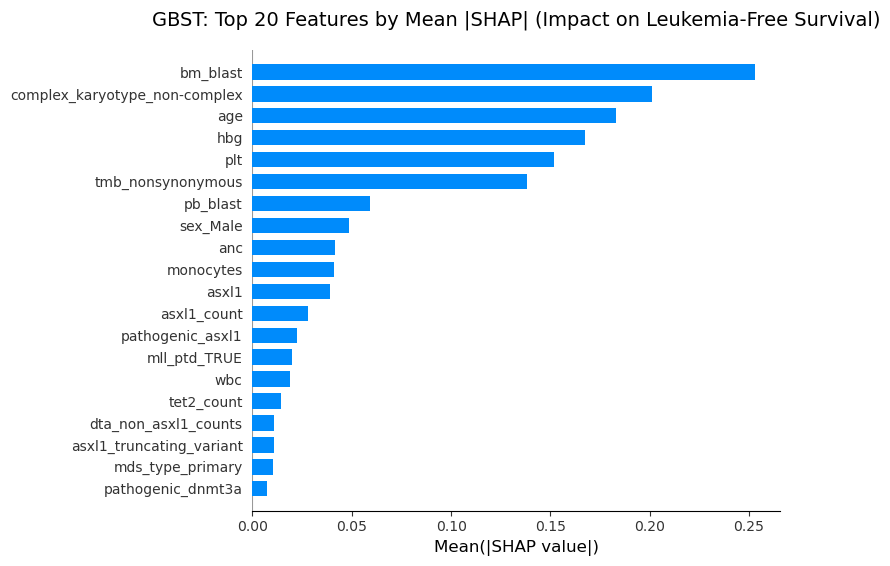

In [ ]:
### SHAP Summary Plots - Bar Plot (Feature Importance) - GBST

# SHAP bar plot for GBST 
shap.summary_plot(
    shap_values_gbst.values,
    X_explain_gbst,
    plot_type="bar",
    show=False,
    max_display=20  # top 20 features
)

fig = plt.gcf()
fig.set_size_inches(8, 6)  # control figure size

# Titles & labels
plt.title(
    "GBST: Top 20 Features by Mean |SHAP| (Impact on Leukemia-Free Survival)",
    fontsize=14,
    pad=18
)
plt.xlabel("Mean(|SHAP value|)", fontsize=12)

# Tidy up fonts and layout
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave room for title

# Save high-res figure
#plt.savefig(FIGURES / "shap_gbst_bar_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_75190/1405473912.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


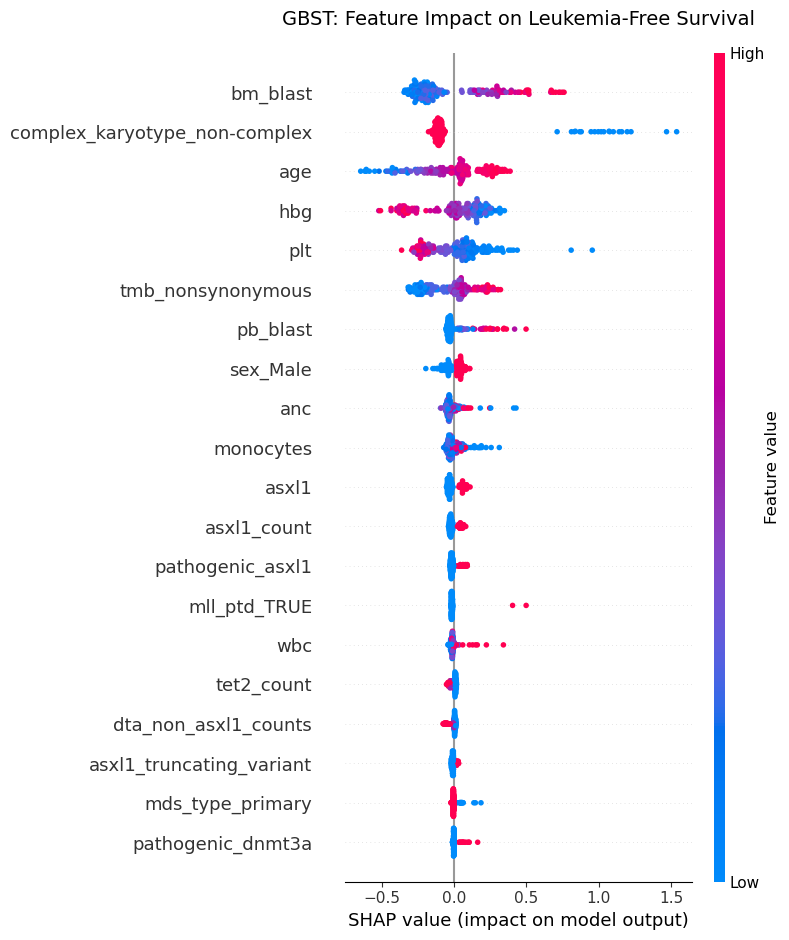


Interpretation:
- Each dot is a patient
- Red = high feature value, Blue = low feature value
- Right side (positive SHAP) = increases risk
- Left side (negative SHAP) = decreases risk


In [ ]:
### SHAP Beeswarm Plot (Feature Impact with Direction) - GBST

plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_gbst.values,
    X_explain_gbst,
    show=False,
    max_display=20  # Show top 20 features
)
plt.title("GBST: Feature Impact on Leukemia-Free Survival", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES / "shap_gbst_beeswarm_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

print("\nInterpretation:")
print("- Each dot is a patient")
print("- Red = high feature value, Blue = low feature value")
print("- Right side (positive SHAP) = increases risk")
print("- Left side (negative SHAP) = decreases risk")

### SHAP dependence plot ASXL1 versus non ASXL1
To better understand the importance of ASXL1 and non-ASXL1 DTA mutations, we plotted them separately

Missing columns: []


<Figure size 700x500 with 0 Axes>

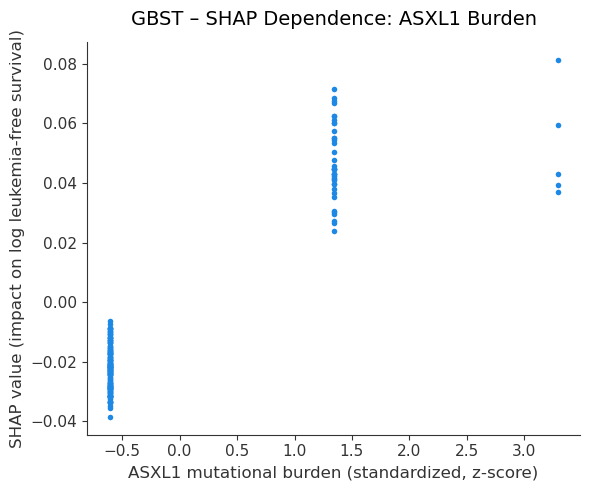

In [49]:
### SHAP Dependence Plot for ASXL1 Burden - GBST

# Ensure 'asxl1_count' is in the DataFrame
needed_cols = ["asxl1_count", "dta_non_asxl1_counts", "asxl1"]
missing = [c for c in needed_cols if c not in X_explain_gbst.columns]
print("Missing columns:", missing)   # should print [] ideally

# For convenience
shap_vals = shap_values_gbst.values  # (n_samples, n_features)


# ASXL1 burden: dependence plot
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "asxl1_count",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,  # pure main effect
    show=False
)
plt.title("GBST – SHAP Dependence: ASXL1 Burden", fontsize=14, pad=12)
plt.xlabel("ASXL1 mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log leukemia-free survival)", fontsize=12)
plt.tight_layout()
#plt.savefig(FIGURES / "dep_asxl1_count_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 700x500 with 0 Axes>

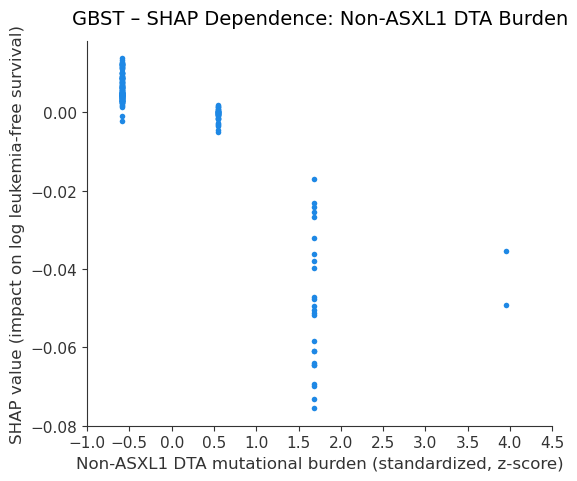

In [50]:
### SHAP Dependence Plot for Non-ASXL1 DTA Burden - GBST

# Ensure 'dta_non_asxl1_counts' is in the DataFrame
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "dta_non_asxl1_counts",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,
    show=False
)

ax = plt.gca()

# Get current x-limits and create ticks every 0.5
xmin, xmax = ax.get_xlim()
xmin = np.floor(xmin * 2) / 2.0
xmax = np.ceil(xmax * 2) / 2.0
ax.set_xticks(np.arange(xmin, xmax + 0.25, 0.5))

plt.title("GBST – SHAP Dependence: Non-ASXL1 DTA Burden", fontsize=14, pad=12)
plt.xlabel("Non-ASXL1 DTA mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log leukemia-free survival)", fontsize=12)
#plt.savefig(FIGURES / "dep_dta_non_asxl1_counts_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 700x500 with 0 Axes>

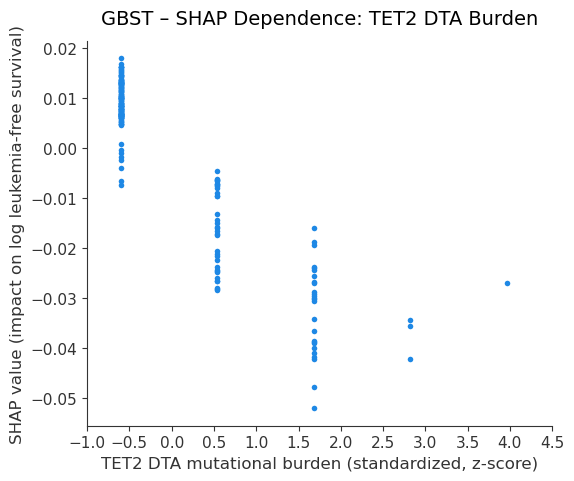

In [51]:
### SHAP Dependence Plot for TET2 DTA Burden - GBST

# Ensure 'tet2_count' is in the DataFrame
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "tet2_count",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,
    show=False
)

ax = plt.gca()

# Get current x-limits and create ticks every 0.5
xmin, xmax = ax.get_xlim()
xmin = np.floor(xmin * 2) / 2.0
xmax = np.ceil(xmax * 2) / 2.0
ax.set_xticks(np.arange(xmin, xmax + 0.25, 0.5))

plt.title("GBST – SHAP Dependence: TET2 DTA Burden", fontsize=14, pad=12)
plt.xlabel("TET2 DTA mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log leukemia-free survival)", fontsize=12)
#plt.savefig(FIGURES / "dep_tet2_count_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()


### SHAP Analysis for Random Survival Forest (RSF)
Analyzed for comparison with GBST

In [52]:
### Rebuild RSF dataframes in the reduced feature space for SHAP (without refit)
# To avoid the error 'X has 45 features, but RandomSurvivalForest is expecting 37 features as input'


# X_train: original training DataFrame (before VarianceThreshold)
# vt: the VarianceThreshold used for RSF
# X_train_rsf, X_test_rsf: the arrays RSF was actually trained on

if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns
    selected_mask = vt.get_support()
    selected_features = original_feature_names[selected_mask]

    X_train_rsf_df = pd.DataFrame(X_train_rsf, columns=selected_features)
    X_test_rsf_df  = pd.DataFrame(X_test_rsf,  columns=selected_features)
else:
    # Fallback if X_train wasn't a DataFrame
    X_train_rsf_df = pd.DataFrame(X_train_rsf)
    X_test_rsf_df  = pd.DataFrame(X_test_rsf)

In [53]:
### SHAP for RSF Model

# Background sample (for SHAP baseline)
X_bg_rsf = X_train_rsf_df.sample(
    n=min(100, X_train_rsf_df.shape[0]),
    random_state=42)

# Test sample to explain
X_explain_rsf = X_test_rsf_df.sample(
    n=min(200, X_test_rsf_df.shape[0]),
    random_state=42)

print(f"Background sample:  {X_bg_rsf.shape}")
print(f"Explanation sample: {X_explain_rsf.shape}")

# SHAP explainer – RSF risk scores
explainer_rsf = shap.Explainer(
    lambda x: rsf_best.predict(x if isinstance(x, np.ndarray) else x.values),
    X_bg_rsf)

print("Computing SHAP values for RSF... (this may take a few minutes)")
shap_values_rsf = explainer_rsf(X_explain_rsf)

print(f"SHAP values shape: {shap_values_rsf.values.shape}")

Background sample:  (100, 42)
Explanation sample: (200, 42)
Computing SHAP values for RSF... (this may take a few minutes)


PermutationExplainer explainer: 201it [1:32:11, 27.66s/it]                         

SHAP values shape: (200, 42)


/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_75190/1826174849.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


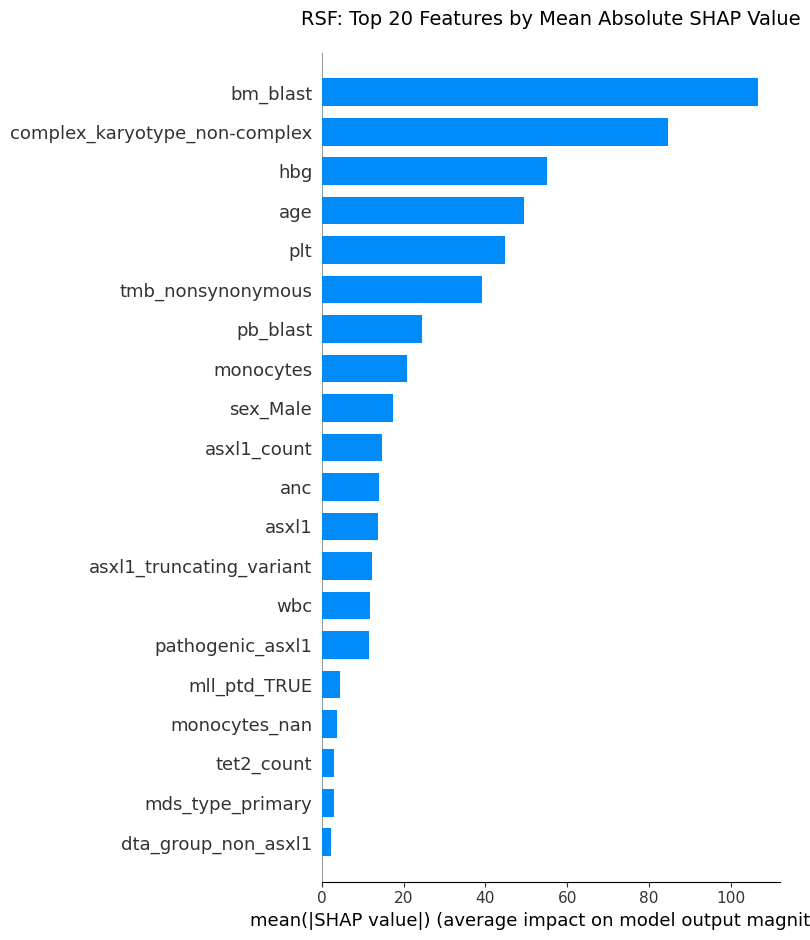

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_75190/1826174849.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


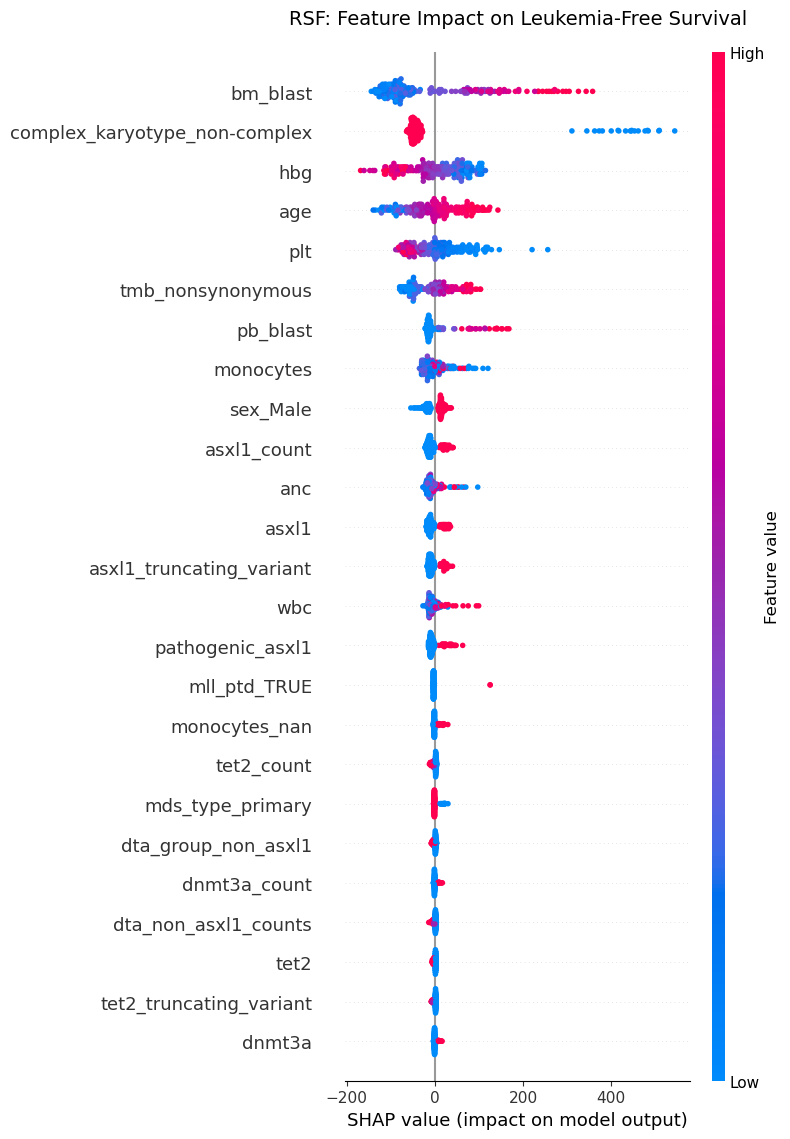

In [ ]:
### RSF SHAP Summary Plots

# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_rsf.values,
    X_explain_rsf,
    plot_type="bar",
    show=False,
    max_display=20)

plt.title("RSF: Top 20 Features by Mean Absolute SHAP Value", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES/"shap_rsf_bar_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_rsf.values,
    X_explain_rsf,
    show=False,
    max_display=25)

plt.title("RSF: Feature Impact on Leukemia-Free Survival", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES/"shap_rsf_beeswarm_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

## Comparison: GBST and RSF

### Feature Importance Comparison: GBST vs RSF

Compare which features are most important across different models.

Top 20 Features by Average SHAP Importance (GBST + RSF):

                      feature  gbst_importance  rsf_importance  avg_importance
                     bm_blast         0.252906      106.719613       53.486260
complex_karyotype_non-complex         0.201273       84.615044       42.408159
                          hbg         0.167358       55.124834       27.646096
                          age         0.182945       49.435413       24.809179
                          plt         0.151682       44.774749       22.463216
            tmb_nonsynonymous         0.138379       39.187745       19.663062
                     pb_blast         0.059104       24.365094       12.212099
                    monocytes         0.041078       20.884795       10.462936
                     sex_Male         0.048580       17.461321        8.754951
                  asxl1_count         0.027707       14.695186        7.361447
                          anc         0.041698       13.835955        6.9

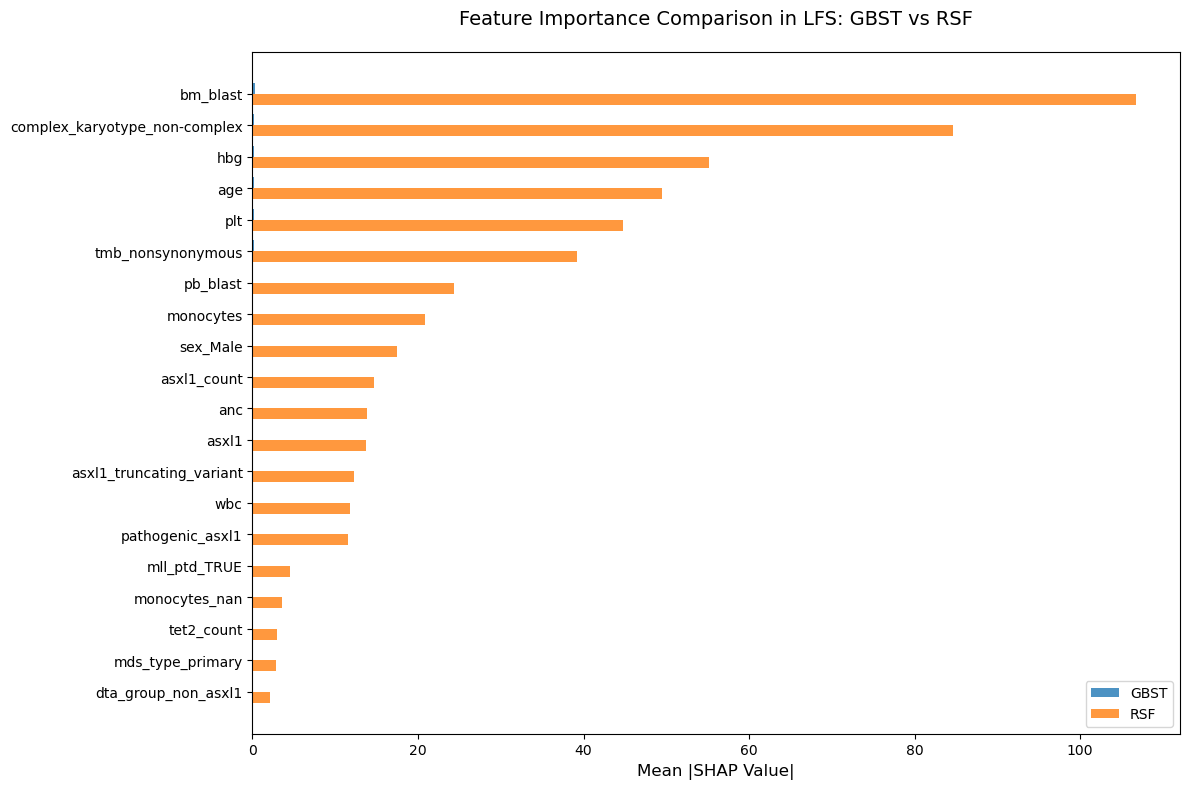

In [55]:
### Compare Feature Importance Across Models

# Calculate mean absolute SHAP values for each model
gbst_importance = pd.DataFrame({
    'feature': X_explain_gbst.columns,
    'gbst_importance': np.abs(shap_values_gbst.values).mean(axis=0)
}).sort_values('gbst_importance', ascending=False)

rsf_importance = pd.DataFrame({
    'feature': X_explain_rsf.columns,
    'rsf_importance': np.abs(shap_values_rsf.values).mean(axis=0)
}).sort_values('rsf_importance', ascending=False)

# Merge and compare
comparison = gbst_importance.merge(rsf_importance, on='feature')
comparison['avg_importance'] = (comparison['gbst_importance'] + comparison['rsf_importance']) / 2
comparison = comparison.sort_values('avg_importance', ascending=False)

# Display top 20 features
print("Top 20 Features by Average SHAP Importance (GBST + RSF):\n")
print(comparison.head(20).to_string(index=False))

# Visualize comparison
top20 = comparison.head(20)
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top20))
width = 0.35

ax.barh(x - width/2, top20['gbst_importance'], width, label='GBST', alpha=0.8)
ax.barh(x + width/2, top20['rsf_importance'], width, label='RSF', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance Comparison in LFS: GBST vs RSF', fontsize=14, pad=20)
ax.legend()

plt.tight_layout()
#plt.savefig(FIGURES/"shap_model_comparison_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()


### Waterfall plot

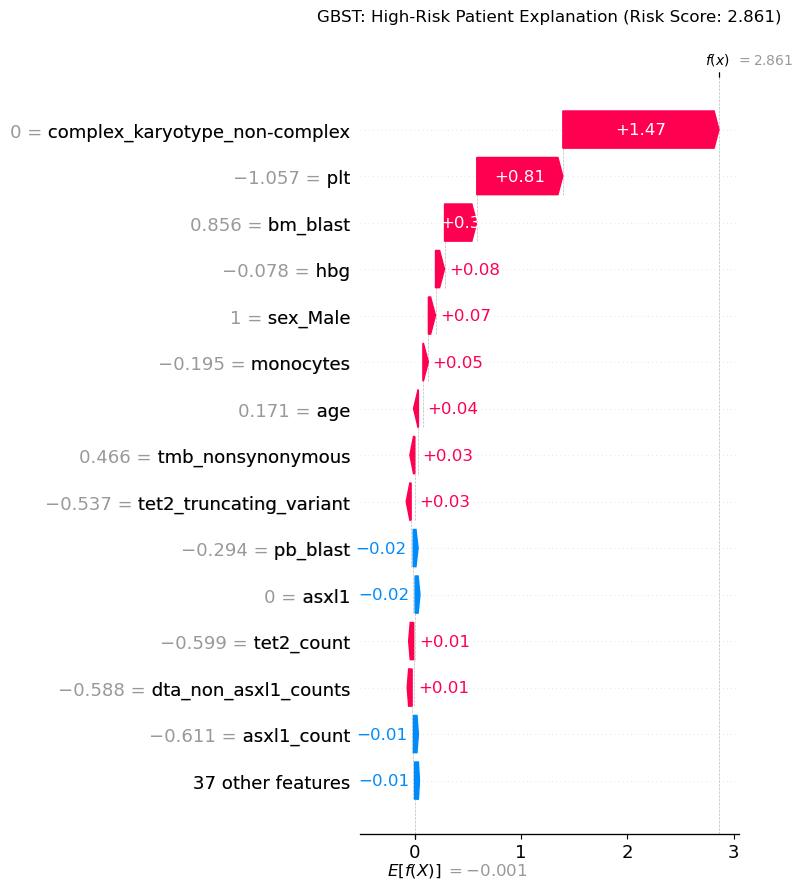

In [56]:

### SHAP Waterfall Plot - High Risk Patient (GBST)

# Find a high-risk patient (high predicted risk score)
gbst_risks = gbst_best.predict(X_explain_gbst.values)
high_risk_idx = np.argmax(gbst_risks)


# Define custom font size
CUSTOM_FONTSIZE = 10

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values_gbst[high_risk_idx], max_display=15, show=False)

#  Access the current axes and iterate through ALL text objects to set font size
ax = plt.gca()

# For feature names, values, SHAP values, etc.
for text in ax.texts:
    text.set_fontsize(CUSTOM_FONTSIZE)

# For x and y tick labels (might be needed if ax.texts doesn't cover them)
ax.tick_params(axis='x', labelsize=CUSTOM_FONTSIZE)
ax.tick_params(axis='y', labelsize=CUSTOM_FONTSIZE * 0.9) # Slightly smaller for long feature names

# For x and y axis labels
ax.set_xlabel(ax.get_xlabel(), fontsize=CUSTOM_FONTSIZE)
ax.set_ylabel(ax.get_ylabel(), fontsize=CUSTOM_FONTSIZE)

# 5. Set the title with desired font size and padding
plt.title(f"GBST: High-Risk Patient Explanation (Risk Score: {gbst_risks[high_risk_idx]:.3f})", 
          fontsize=CUSTOM_FONTSIZE + 2, 
          pad=40) # Increase padding

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
#plt.savefig(OUTPUT/"shap_waterfall_high_risk_gbst_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

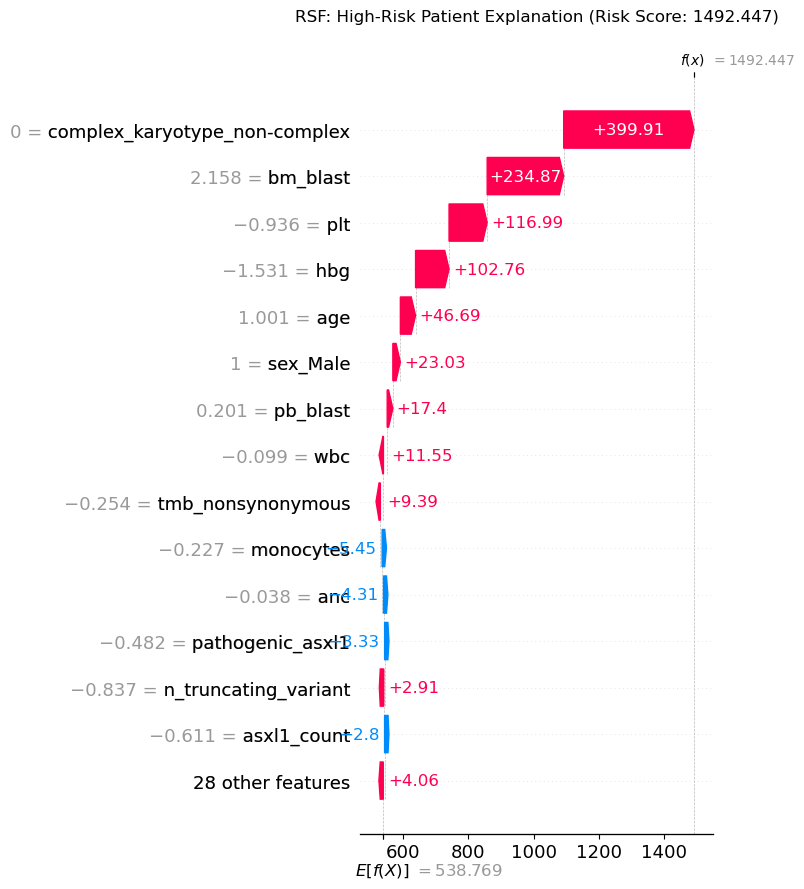

In [57]:
### SHAP Waterfall Plot - High Risk Patient (RSF)

# Find a high-risk patient (high predicted risk score)
rsf_risks = rsf_best.predict(X_explain_rsf.values)
high_risk_idx = np.argmax(rsf_risks)


#  Define custom font size
CUSTOM_FONTSIZE = 10

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values_rsf[high_risk_idx], max_display=15, show=False)

#  Access the current axes and iterate through ALL text objects to set font size
ax = plt.gca()

# For feature names, values, SHAP values, etc.
for text in ax.texts:
    text.set_fontsize(CUSTOM_FONTSIZE)

# For x and y tick labels (might be needed if ax.texts doesn't cover them)
ax.tick_params(axis='x', labelsize=CUSTOM_FONTSIZE)
ax.tick_params(axis='y', labelsize=CUSTOM_FONTSIZE * 0.9) # Slightly smaller for long feature names

# For x and y axis labels
ax.set_xlabel(ax.get_xlabel(), fontsize=CUSTOM_FONTSIZE)
ax.set_ylabel(ax.get_ylabel(), fontsize=CUSTOM_FONTSIZE)

#  Set the title with desired font size and padding
plt.title(f"RSF: High-Risk Patient Explanation (Risk Score: {rsf_risks[high_risk_idx]:.3f})", 
          fontsize=CUSTOM_FONTSIZE + 2, 
          pad=40) # Increase padding

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
#plt.savefig(FIGURES/"shap_waterfall_high_risk_rsf_lfs.tiff", dpi=300, bbox_inches="tight")
plt.show()

### Export SHAP Values for Further Analysis

In [58]:
### Export SHAP Values and Feature Importance

# Export GBST SHAP values
shap_df_gbst = pd.DataFrame(
    shap_values_gbst.values,
    columns=X_explain_gbst.columns,
    index=X_explain_gbst.index)

#shap_df_gbst.to_csv(OUTPUT/"shap_values_gbst_lfs.csv")

# Export RSF SHAP values
shap_df_rsf = pd.DataFrame(
    shap_values_rsf.values,
    columns=X_explain_rsf.columns,
    index=X_explain_rsf.index)

#shap_df_rsf.to_csv(OUTPUT/"shap_values_rsf_lfs.csv")

# Export feature importance comparison
#comparison.to_csv(OUTPUT/"shap_feature_importance_comparison_lfs.csv", index=False)


# END